TODO: 
- A problem is that now I barely have enough smaller filters to represent the entire patch, perhaps I should eliminate one of the spatial frequencies (so I end up with 3). These gabor pyramids are just a lot better already than the OG baseline. 
- Another thing that could cause the problems might have to do with the voxel selection, perhaps beacuse the original baseline was so terrible, it was not too important which voxels you were trying to model the activity of. I already lightly tried this out by changing the max pRF size to 1 again, but could be done more strict, also by turning the lower bound up.
- Don't overthink the code I wrote for the pyramid filter creation, in the end it should be the most simple but funcitonal pyramid of which we can argue that it is sensible to be used as a baseline. For this, a very important argument is that the filters fall entirely inside the patch of interest. (Also improvement compared to the spatial coherence feats), furthermore it should jsut correspond to feedforward sweep information. I'm surprised by how good it is, well, compared to RMS, SC, CE.
- I need to check whether the normalisation is still done correctly, because I'm not sure. The code that I wrote to distinguish between the different orientations had to be aggregated, and there might've been some uncareful coding there. Check this, and otherwise think of a better way of doing it. It should work but I need to be sure that it's solid. I still have the old select_filters code in my local notebook.
- I need to think about the quality of the unpredictability scores, could it be that they are wack because I extract the feature maps now at every convolutional layer? In Micha's paper the V1 delta r is in the range 0 to 0.1, which is not what I'm achieving now anymore.
- I need to complete the cycle so that I can also inspect the beta coefficients, however, it is important that my delta r scores are positive in all situations, which they are not right now (most notably they are postiive for V3 and V4 but tend to be negative in V1 and V2).


In [1]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


file_exists


['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


False

In [2]:
from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    select_filters,
    cut_paste_mask,
)


In [3]:
# dir1 = NSP.stimuli.load_gabor_output("subj01", "all_imgs_sf4_dir6", verbose=True, peri_ecc=2.0, peri_angle=210)
# dir1 = NSP.stimuli.load_gabor_output("subj01", "all_imgs_sf4_dir6_ecc2.0_angle330", verbose=True)
dir1 = NSP.stimuli.load_gabor_output("subj01", "all_imgs_sf4_dir9", verbose=True)

Processing file: gabor_baseline_all_imgs_sf4_dir90_1000.npy
Batch 0 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir91000_2000.npy
Batch 1 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir92000_3000.npy
Batch 2 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir93000_4000.npy
Batch 3 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir94000_5000.npy
Batch 4 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir95000_6000.npy
Batch 5 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir96000_7000.npy
Batch 6 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir97000_8000.npy
Batch 7 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir98000_9000.npy
Batch 8 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir99000_10000.npy
Batch 9 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir910000_11000.npy
Batch 10 shape: (1000, 972)
Processin

In [4]:
from scipy.stats import zscore as zs

# kak = zs(dir1)

NSP.utils.inspect_dat(dir1)


Lowest value: -21.124391555786133
Highest value: 2.034973621368408
Mean value: -0.006845366209745407
Standard deviation: 1.0221604108810425


### Visually inspect filter selections from scripts

In [10]:
subject = "subj01"
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees
peri_ecc = 0
peri_angle = 0

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)


gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

if peri_ecc != 0 and peri_angle != 0:
    print(f"Working with a peripheral patch at {peri_ecc} degrees eccentricity and {peri_angle} degrees angle")
    peri_patch = cut_paste_mask(gauss_check_stack, peri_angle, peri_ecc, verbose=False, plot=False)
    peri_gauss = cut_paste_mask(np.stack([gauss, gauss], axis=0), peri_angle, peri_ecc, verbose=False, plot=False)
    gauss_check_stack = np.stack([peri_gauss, peri_patch], axis=0)


# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
spat_freqs = [4.2, 8.4, 16.8, 33.6] #### THis was the previous list of spatial frequencies
# spat_freqs = [8.4, 16.8, 33.6] # Extreme option with only 2 spatial frequencies

# spat_dirs = tuple(range(0, 180, 30)) # Original one
spat_dirs = tuple(range(0,180,20)) # non-lenient one
filter_space = 1 # used to be 1.5 

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                spatial_frequencies=spat_freqs, # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=spat_dirs,
                                                sf_gauss_ratio=.25, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=filter_space,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

checkpyramid.view.nfilters

### THis is important code for the direction filtering

# Get all directions
directions = [checkpyramid.view.filters[i]['direction'] for i in range(checkpyramid.view.nfilters)]

# Get unique directions
unique_directions = np.unique(directions)

# Initialize an empty array to store the masks
direction_masks = np.zeros((len(unique_directions), checkpyramid.view.nfilters), dtype=bool)

# Create a mask for each unique direction
for i, direction in enumerate(unique_directions):
    direction_masks[i] = np.array(directions) == direction
    

In [11]:
print(checkpyramid.nfilters)

211428


In [7]:
gauss_output = np.load("/home/rfpred/data/custom_files/visfeats/gabor_pyramid/gauss_checker_output_all_imgs_sf4_dir6.npy")
# gauss_output = np.load("/home/rfpred/data/custom_files/visfeats/peripheral/ecc2.0_angle330/gabor_pyramid/gauss_checker_output_all_imgs_sf4_dir6.npy")
# Figure out how many filters there are per spatial frequency
filters_per_freq= []
for sf in spat_freqs:

    all_filters = checkpyramid.view.filters
    count = sum(1 for d in all_filters if d.get('spatial_freq') == sf)
    filters_per_freq.append(count)
    
filters_per_freq

output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=spat_freqs,
        direction_masks=direction_masks,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99.95, # Het moet maar
        plot=False,
        verbose=True,
    )
)

# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)


# The indices for the filters that are within the patch
# filter_indices = np.where(filter_selection == True)[0]
filter_indices = np.where(full_filter == True)[0]


Processing file: gabor_baseline_all_imgs_sf4_dir90_1000.npy
Batch 0 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir91000_2000.npy
Batch 1 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir92000_3000.npy
Batch 2 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir93000_4000.npy
Batch 3 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir94000_5000.npy
Batch 4 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir95000_6000.npy
Batch 5 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir96000_7000.npy
Batch 6 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir97000_8000.npy
Batch 7 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir98000_9000.npy
Batch 8 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir99000_10000.npy
Batch 9 shape: (1000, 972)
Processing file: gabor_baseline_all_imgs_sf4_dir910000_11000.npy
Batch 10 shape: (1000, 972)
Processin

ValueError: operands could not be broadcast together with shapes (972,) (2025,) 

(198, 425, 425)


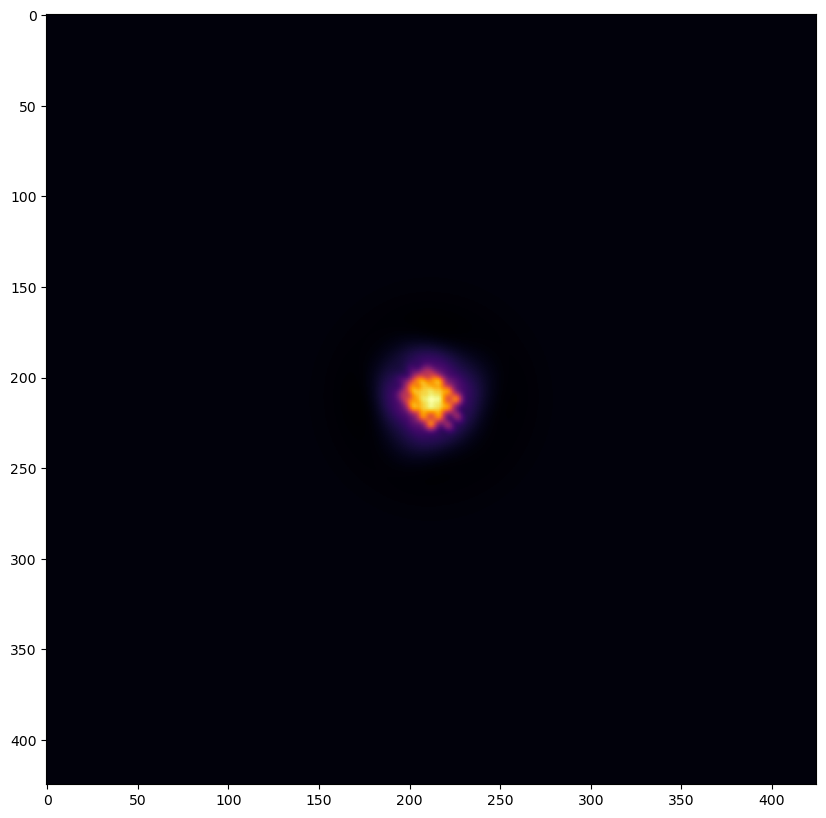

In [71]:
filt_stack = []

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    for filt_no in range(len(filter_selection_dictlist[dir])):
    
        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                                    centerh=fdict['centerh'],
                                    centerv=fdict['centerv'],
                                    direction=fdict['direction'],
                                    spatial_freq=fdict['spatial_freq'],
                                    spatial_env=fdict['spatial_env'],
                                    temporal_freq=fdict['temporal_freq'],
                                    filter_temporal_width=fdict['filter_temporal_width'],
                                    aspect_ratio=fdict['aspect_ratio'],
                                    stimulus_fps=fdict['stimulus_fps'],
                                    spatial_phase_offset=fdict['spatial_phase_offset'],)

        filt_stack.append(aars[1])


filt_stack = np.array(filt_stack)
print(filt_stack.shape)

fig, axes = plt.subplots(figsize=(10, 10))
plt.imshow(np.mean(filt_stack, axis=0), cmap="inferno")


212.0 212.0
(162, 262, 162, 262)


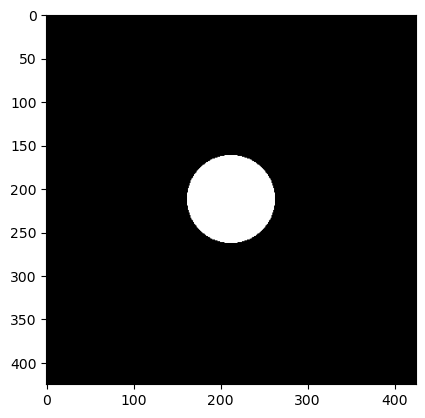

In [75]:
# x_pix, y_pix = [(coord * pix_per_deg + 212) for coord in list(NSP.utils.ecc_angle_to_coords(2, 210))]
# x_rad, y_rad = NSP.utils.ecc_angle_to_coords(2, 330)
x_rad, y_rad = NSP.utils.ecc_angle_to_coords(0, 0)
x_pix = x_rad * pix_per_deg + 212
y_pix = 212 - y_rad * pix_per_deg
print(x_pix, y_pix)
circ = NSP.utils.make_circle_mask(425, y_pix, x_pix, 1 * pix_per_deg)

plt.imshow(circ, cmap="binary_r")

bounds = NSP.utils.get_bounding_box(circ)

print(bounds)

(33, 425, 425)


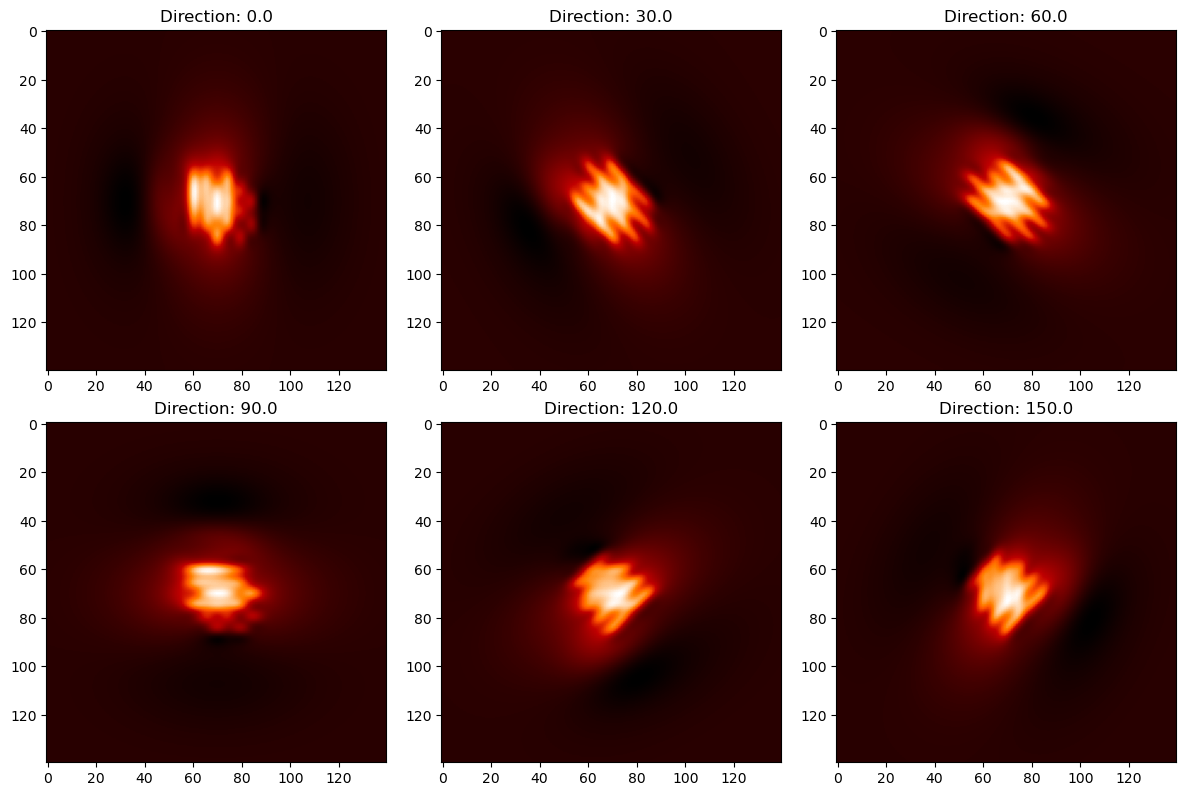

In [76]:

margin = 20
# filt_stack = []
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    filt_stack = []

    for filt_no in range(len(filter_selection_dictlist[dir])):
    # for filt_no in [20]:
        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                                    centerh=fdict['centerh'],
                                    centerv=fdict['centerv'],
                                    direction=fdict['direction'],
                                    spatial_freq=fdict['spatial_freq'],
                                    spatial_env=fdict['spatial_env'],
                                    temporal_freq=fdict['temporal_freq'],
                                    filter_temporal_width=fdict['filter_temporal_width'],
                                    aspect_ratio=fdict['aspect_ratio'],
                                    stimulus_fps=fdict['stimulus_fps'],
                                    spatial_phase_offset=fdict['spatial_phase_offset'],)

        filt_stack.append(aars[1])

    # Calculate the mean heatmap
    mean_heatmap = np.mean(filt_stack, axis=0)

    # Determine the subplot row and column
    row = dir_no // 3
    col = dir_no % 3

    # Plot the mean heatmap in the appropriate subplot
    ax[row, col].imshow(mean_heatmap[(bounds[2]-margin):(bounds[3]+margin),(bounds[0]-margin):(bounds[1]+margin)], cmap="gist_heat")

    # Set the title of the subplot to include the direction info
    ax[row, col].set_title(f"Direction: {fdict['direction']}")

filt_stack = np.array(filt_stack)
print(filt_stack.shape)
fig.tight_layout()

In [273]:
mean_heatmap.max()

0.9997229972155014

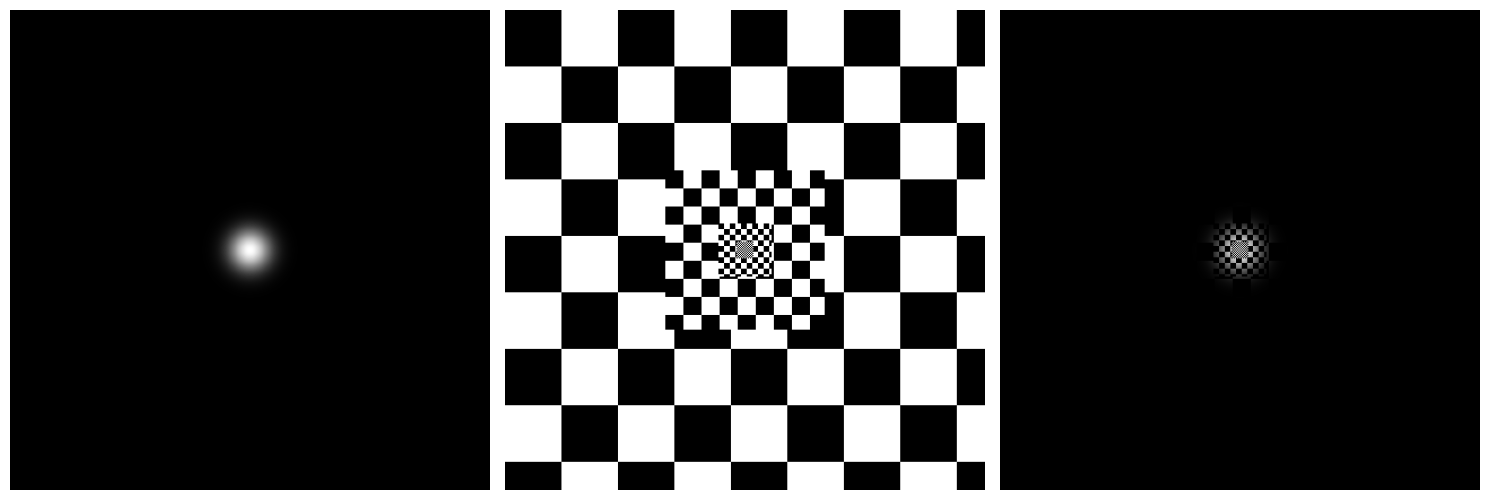

In [4]:
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

In [5]:
spat_freqs = [4.2, 8.4, 16.8, 33.6] #### THis was the previous list of spatial frequencies
# spat_freqs = [8.4, 16.8, 33.6] # Extreme option with only 2 spatial frequencies

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                spatial_frequencies=spat_freqs, # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 45)),
                                                sf_gauss_ratio=.25, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=2,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

In [6]:
### THis is important code for the direction filtering

# Get all directions
directions = [checkpyramid.view.filters[i]['direction'] for i in range(checkpyramid.view.nfilters)]

# Get unique directions
unique_directions = np.unique(directions)

# Initialize an empty array to store the masks
direction_masks = np.zeros((len(unique_directions), checkpyramid.view.nfilters), dtype=bool)

# Create a mask for each unique direction
for i, direction in enumerate(unique_directions):
    direction_masks[i] = np.array(directions) == direction
  
  
  
trial_no = 3 # For which script trial do you want to fetch the projected filter outputs
gauss_output =  np.load(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_trial{trial_no}.npy")
  


In [7]:
direction_masks

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

In [8]:
# # Check if there's still a file with the filter selection, saves time

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_{args.filetag}.npy")

# if file_exists:
#     print("Loading the filter selection from file")
#     gauss_output = np.load(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_{args.filetag}.npy")
# else:
#     gauss_output = checkpyramid.project_stimulus(gauss_check_stack)
#     np.save(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output_{args.filetag}.npy", gauss_output)

# Figure out how many filters there are per spatial frequency
filters_per_freq= []
for sf in spat_freqs:

    all_filters = checkpyramid.view.filters
    count = sum(1 for d in all_filters if d.get('spatial_freq') == sf)
    filters_per_freq.append(count)
    
filters_per_freq

[196, 900, 4356, 17956]

In [45]:
from scipy.stats import zscore as zs

def select_filters(
    pyramid,
    output,
    imgs: np.ndarray,
    img_no: int,
    spat_freqs: list[float],
    direction_masks: list|tuple,
    filters_per_freq: list[float],
    percentile_cutoff: float = 99,
    best_n: int = None,
    plot: bool = False,
    verbose: bool = False,
):
    """
    Selects filters from a pyramid based on the given parameters.
    """
    this_output=output[img_no]
    n_spatfreqs = len(spat_freqs)

    # Initialize the aggregated results
    output_norm_agg = []
    filter_selection_agg = []
    filters_per_freq_sel_agg = []

    # Loop over the different directions
    for dir_no in range(len(direction_masks)):
        # Normalize the output for every spatial frequency separately
        start = 0
        output_norm = []
        for i in range(n_spatfreqs):
            end = start + filters_per_freq[i]
            this_dir_mask = direction_masks[dir_no][start:end]
            output_norm.append(zs(this_output[start:end] * this_dir_mask))
            start = end

        # Calculate the nth percentile for each spatial frequency and create a boolean mask
        filter_selection = []
        filters_per_freq_sel = []
        for i in range(n_spatfreqs):
            if best_n is not None:
                # Select the top best_n filters
                sorted_indices = np.argsort(output_norm[i])
                mask = np.zeros_like(output_norm[i], dtype=bool)
                mask[sorted_indices[-best_n:]] = True
            else:
                # Use percentile cutoff
                percentile = np.percentile(output_norm[i], percentile_cutoff)
                mask = output_norm[i] > percentile

            filter_selection.append(mask)
            n_filters = np.sum(mask)
            filters_per_freq_sel.append(n_filters)
            if verbose:
                print(
                    f"Direction {dir_no}, Spatial frequency {i}: number of values > percentile = {n_filters}"
                )

        # Aggregate the results
        output_norm_agg.append(output_norm)
        filter_selection_agg.append(filter_selection)
        filters_per_freq_sel_agg.append(filters_per_freq_sel)

    # Boolean mask to filter out the selected filters
    filter_selection_agg = [np.concatenate(fs) for fs in filter_selection_agg]

    # Dictionary of the selected filters
    filter_selection_dictlist = [list(np.array(pyramid.view.filters)[fs]) for fs in filter_selection_agg]
    
    if verbose:
        for dir_no, fs in enumerate(filter_selection_agg):
            print(
                f"Direction {dir_no}: Filter includes {np.sum(fs)} out of {pyramid.view.nfilters} filters"
            )
    if plot:
        for dir_no, fs in enumerate(filter_selection_agg):
            show(imgs[img_no], figsize=(6, 6))
            plot_filter_locations(
                gabor_pyramid=pyramid, in_range=fs, pixdims=(425, 425)
            )
        
    return output_norm_agg, filters_per_freq_sel_agg, filter_selection_agg, filter_selection_dictlist

In [10]:
output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=spat_freqs,
        direction_masks=direction_masks,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99.75, # Het moet maar
        best_n = 2,
        plot=False,
        verbose=True,
    )
)

# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)


Direction 0, Spatial frequency 0: number of values > percentile = 2
Direction 0, Spatial frequency 1: number of values > percentile = 2
Direction 0, Spatial frequency 2: number of values > percentile = 2
Direction 0, Spatial frequency 3: number of values > percentile = 2
Direction 1, Spatial frequency 0: number of values > percentile = 2
Direction 1, Spatial frequency 1: number of values > percentile = 2
Direction 1, Spatial frequency 2: number of values > percentile = 2
Direction 1, Spatial frequency 3: number of values > percentile = 2
Direction 2, Spatial frequency 0: number of values > percentile = 2
Direction 2, Spatial frequency 1: number of values > percentile = 2
Direction 2, Spatial frequency 2: number of values > percentile = 2
Direction 2, Spatial frequency 3: number of values > percentile = 2
Direction 3, Spatial frequency 0: number of values > percentile = 2
Direction 3, Spatial frequency 1: number of values > percentile = 2
Direction 3, Spatial frequency 2: number of valu

In [46]:
def show_random_filter(pyramid, filter, return_array:bool=False):
    # The indices for the filters that are within the patch
    filter_indices = np.where(filter == True)[0]
    this_filter = random.choice(filter_indices)
    pyramid.view.show_filter(this_filter, return_array=return_array)
    plt.show()


ui = show_random_filter(checkpyramid, full_filter, return_array=True)
# show_random_filter(checkpyramid, direction_masks[0] * full_filter)

NameError: name 'checkpyramid' is not defined

In [185]:
filter_selection_dictlist

[[{'centerh': 0.6785714285714286,
   'centerv': 0.5892857142857143,
   'direction': 0.0,
   'spatial_freq': 4.2,
   'spatial_env': 0.05952380952380952,
   'temporal_freq': 0.0,
   'temporal_env': inf,
   'filter_temporal_width': 1.0,
   'aspect_ratio': 1.0,
   'stimulus_fps': 1.0,
   'spatial_phase_offset': 0.0},
  {'centerh': 0.6785714285714286,
   'centerv': 0.6339285714285714,
   'direction': 0.0,
   'spatial_freq': 8.4,
   'spatial_env': 0.02976190476190476,
   'temporal_freq': 0.0,
   'temporal_env': inf,
   'filter_temporal_width': 1.0,
   'aspect_ratio': 1.0,
   'stimulus_fps': 1.0,
   'spatial_phase_offset': 0.0},
  {'centerh': 0.7232142857142857,
   'centerv': 0.6339285714285714,
   'direction': 0.0,
   'spatial_freq': 8.4,
   'spatial_env': 0.02976190476190476,
   'temporal_freq': 0.0,
   'temporal_env': inf,
   'filter_temporal_width': 1.0,
   'aspect_ratio': 1.0,
   'stimulus_fps': 1.0,
   'spatial_phase_offset': 0.0},
  {'centerh': 0.6785714285714286,
   'centerv': 0.61160

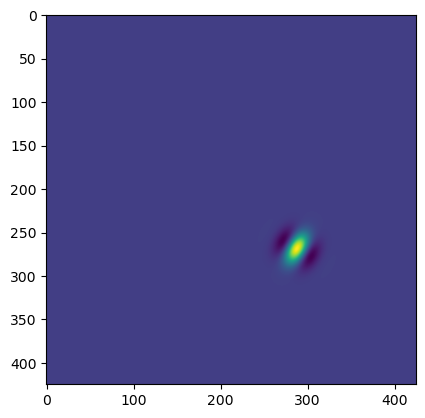

In [214]:
# filter_selection_dictlist[0]
dir = 5
filt_no = 1
fdict = filter_selection_dictlist[dir][filt_no]

# soep = moten.viz.plot_3dgabor(filter_selection_dictlist,title="soup", speed=1, time_padding=False)

aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                              centerh=fdict['centerh'],
                              # centerh=.5,
                              centerv=fdict['centerv'],
                              # centerv=.5,
                              direction=fdict['direction'],
                              spatial_freq=fdict['spatial_freq'],
                              spatial_env=fdict['spatial_env'],
                              temporal_freq=fdict['temporal_freq'],
                              filter_temporal_width=fdict['filter_temporal_width'],
                              aspect_ratio=fdict['aspect_ratio'],
                              stimulus_fps=fdict['stimulus_fps'],
                              spatial_phase_offset=fdict['spatial_phase_offset'],)

plt.imshow(aars[1])

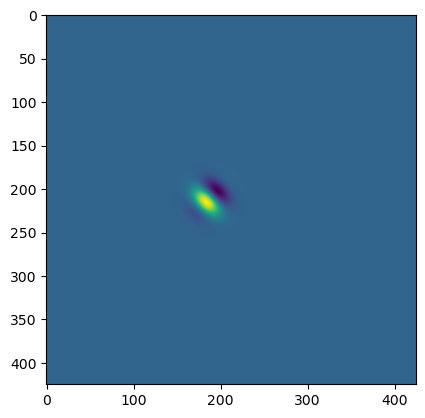

In [87]:
plt.imshow(np.mean(np.stack((aars[0],aars[1])), axis=0))

In [98]:



for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    # dir = 1
    print(dir_no)
    filt_no = 2
    fdict = filter_selection_dictlist[dir][filt_no]

    # soep = moten.viz.plot_3dgabor(filter_selection_dictlist,title="soup", speed=1, time_padding=False)

    aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                                centerh=fdict['centerh'],
                                centerv=fdict['centerv'],
                                direction=fdict['direction'],
                                spatial_freq=fdict['spatial_freq'],
                                spatial_env=fdict['spatial_env'],
                                temporal_freq=fdict['temporal_freq'],
                                filter_temporal_width=fdict['filter_temporal_width'],
                                aspect_ratio=fdict['aspect_ratio'],
                                stimulus_fps=fdict['stimulus_fps'],
                                spatial_phase_offset=fdict['spatial_phase_offset'],)

    if dir_no == 0:
        filt_stack = aars[0]
    else:
        filt_stack = np.append((filt_stack, aars[0]))
    

filt_stack.shape            
# plt.imshow(filt_stack)

0
1


TypeError: append() missing 1 required positional argument: 'values'

In [29]:
filt_stack = []

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    for filt_no in range(len(filter_selection_dictlist[dir])):
        
        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                                    centerh=fdict['centerh'],
                                    centerv=fdict['centerv'],
                                    direction=fdict['direction'],
                                    spatial_freq=fdict['spatial_freq'],
                                    spatial_env=fdict['spatial_env'],
                                    temporal_freq=fdict['temporal_freq'],
                                    filter_temporal_width=fdict['filter_temporal_width'],
                                    aspect_ratio=fdict['aspect_ratio'],
                                    stimulus_fps=fdict['stimulus_fps'],
                                    spatial_phase_offset=fdict['spatial_phase_offset'],)

        filt_stack.append(aars[1])

filt_stack = np.array(filt_stack)
print(filt_stack.shape)


plt.imshow(np.mean(filt_stack, axis=0), cmap="hot")

NameError: name 'filter_selection_dictlist' is not defined

In [2]:
# !{sys.executable} -m pip install pymoten

DEPRECATION: Loading egg at /home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


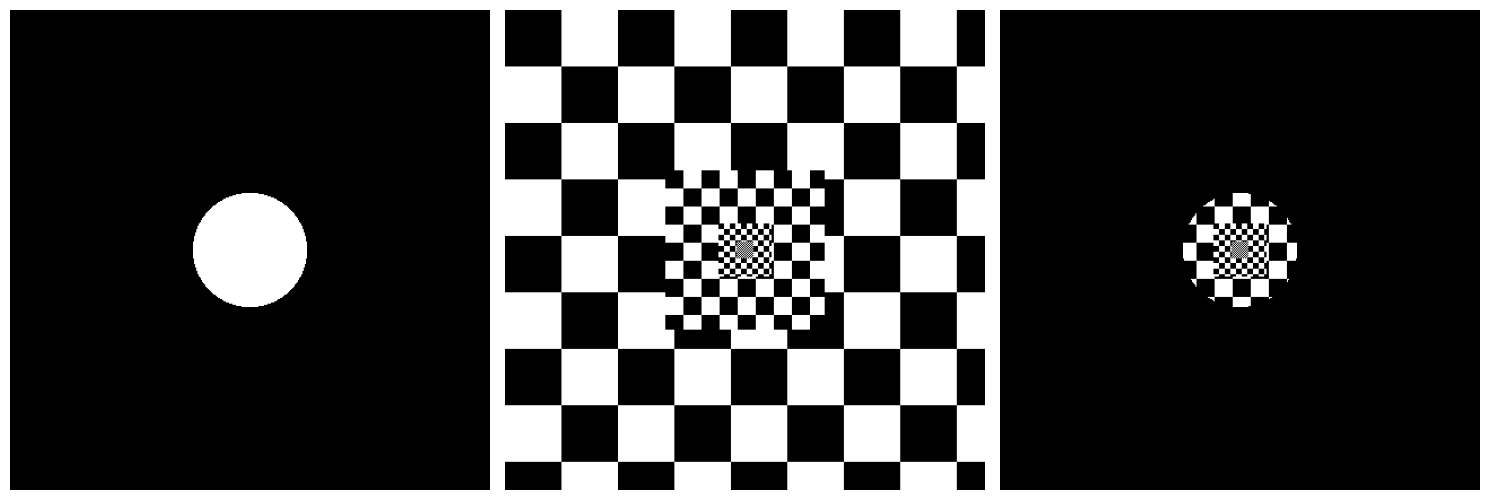

In [47]:
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([cirkel, checker_stim, checker_stim * cirkel]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

circ_check_stack = np.stack([cirkel, checker_stim * cirkel], axis=0)

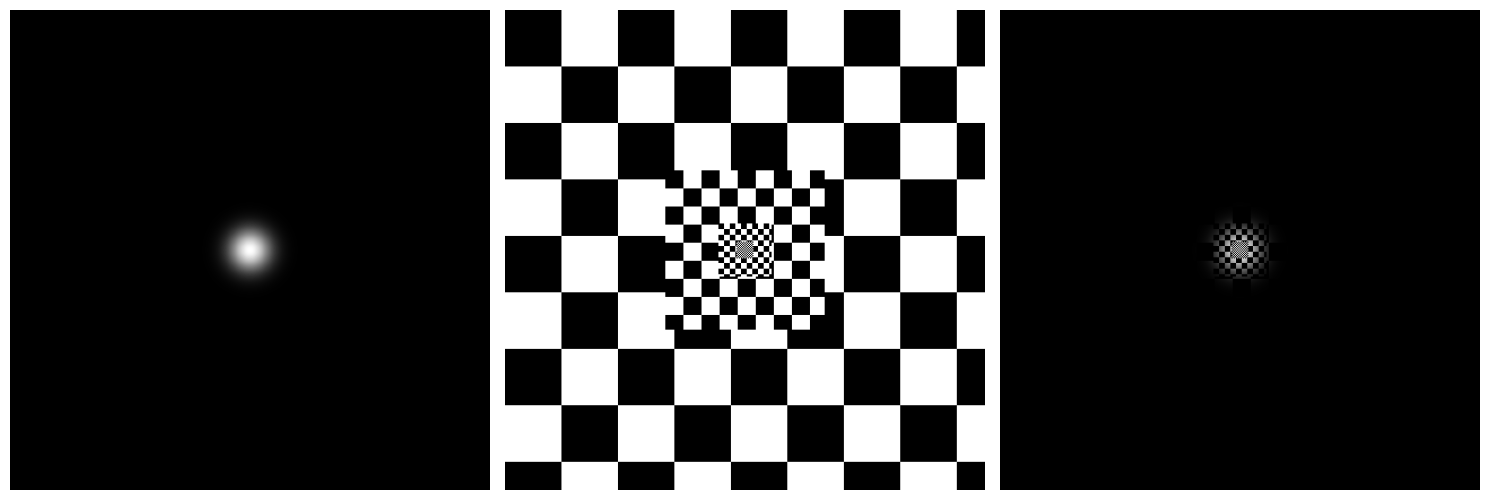

In [48]:
gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)


### New implementation to figure out what is the most feasible gabor pyramid (balance between overkill and biological relevance)

In [58]:
# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
spat_freqs = [4.2, 8.4, 16.8, 33.6]

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                spatial_frequencies=[4.2, 8.4, 16.8, 33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 45)),
                                                sf_gauss_ratio=1, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=.5,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

checkpyramid.view.nfilters

24112

### This is the old code (or the first tryout) of which the pyramid is still way too strong

In [28]:
# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
spat_freqs = [4.2, 8.4, 16.8, 33.6]

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                spatial_frequencies=[4.2, 8.4, 16.8, 33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 20)),
                                                sf_gauss_ratio=1, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=.5,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,)

checkpyramid.view.nfilters

NameError: name 'gauss_check_stack' is not defined

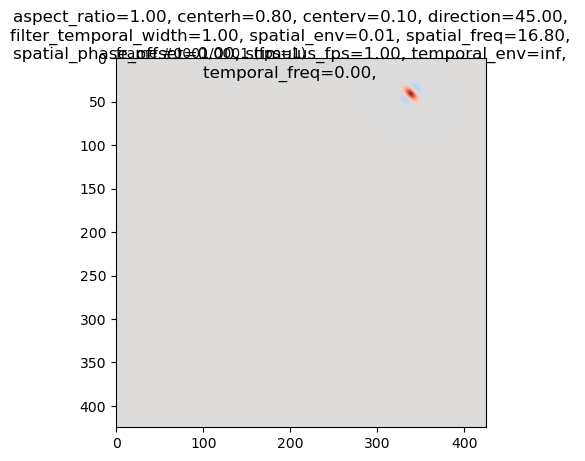

In [57]:
checkpyramid.view.show_filter(random.randint(0, checkpyramid.view.nfilters))
plt.show()

In [ ]:
circle_output = checkpyramid.project_stimulus(circ_check_stack)

In [17]:
gauss_output = checkpyramid.project_stimulus(gauss_check_stack)

project_stimulus: 100%|██████████| 54252/54252 [12:07<00:00, 74.56it/s]


In [65]:
pyr_pars = {
    'spatial_frequencies': [4.2, 8.4, 16.8, 33.6],
    'spatial_orientations': tuple(range(0, 180, 30)),
    'sf_gauss_ratio': 1,
    'max_spatial_env': 1/8.4,
    'filter_spacing': .5,
    'spatial_phase_offset': 0
}

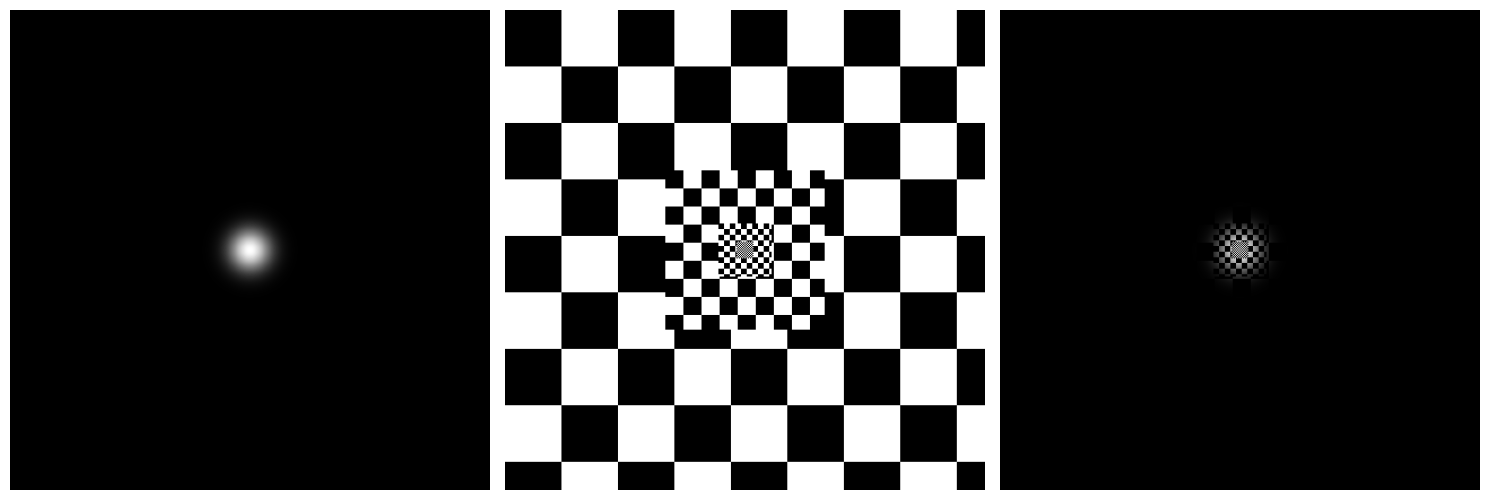

In [61]:
subject = "subj01"
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees
peri_ecc = 0
peri_angle = 0

gauss = isotropic_gaussian(dims=(425,425), sigma=pix_per_deg/4) # Justify this 2.5 factor

checker_stim = make_checker(dims=(425,425), checkercenter=(212,212), scales=3, scaling_factor=3, checker_size=50, stride=0)

fig, axes = plt.subplots(1, 3, figsize=(15,6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap='gist_gray')
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)


In [66]:
checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=gauss_check_stack,
                                                         **pyr_pars)

In [19]:
# Figure out how many filters there are per spatial frequency
filters_per_freq= []
for sf in spat_freqs:

    all_filters = checkpyramid.view.filters
    count = sum(1 for d in all_filters if d.get('spatial_freq') == sf)
    filters_per_freq.append(count)
    
filters_per_freq

[2025, 2025, 9801, 40401]

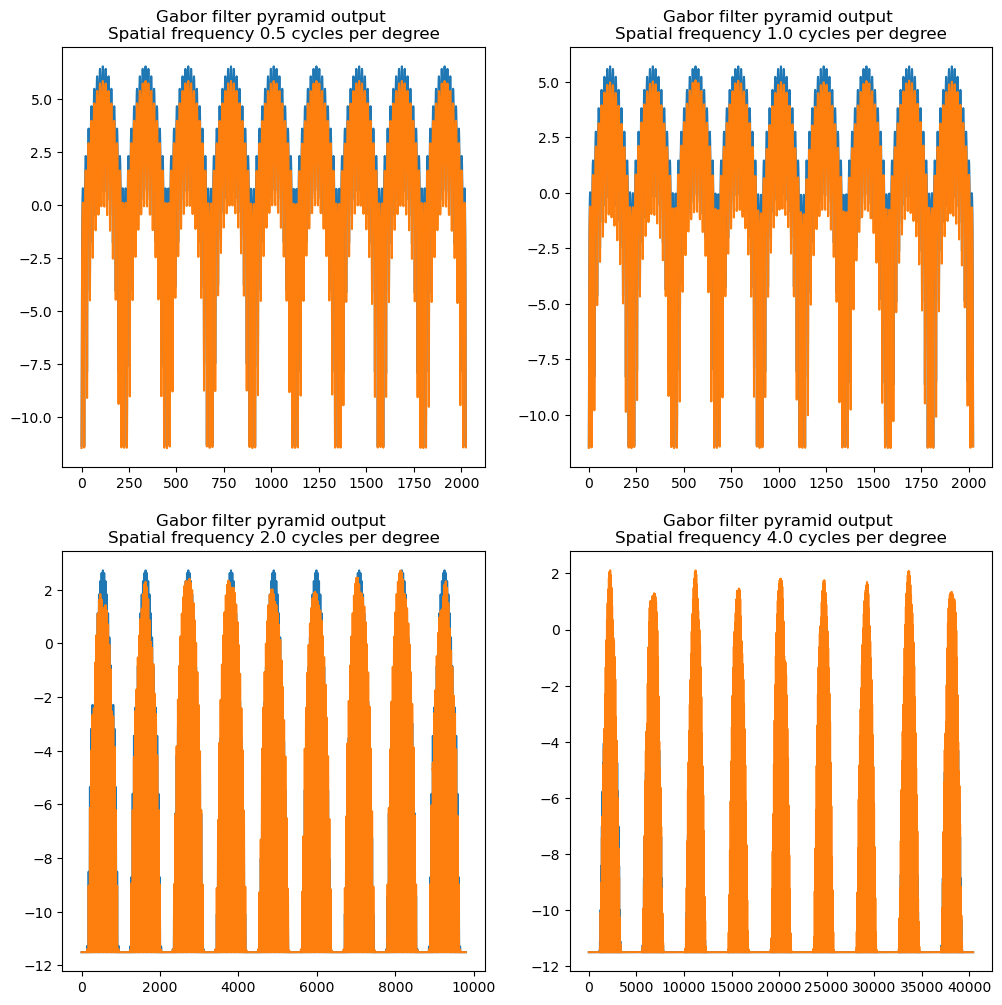

In [21]:
plot_filter_outputs(sel_output=gauss_output,
                    filters_per_freq_sel=filters_per_freq,
                    spat_freqs=spat_freqs,
                    img_indices=[0,1])

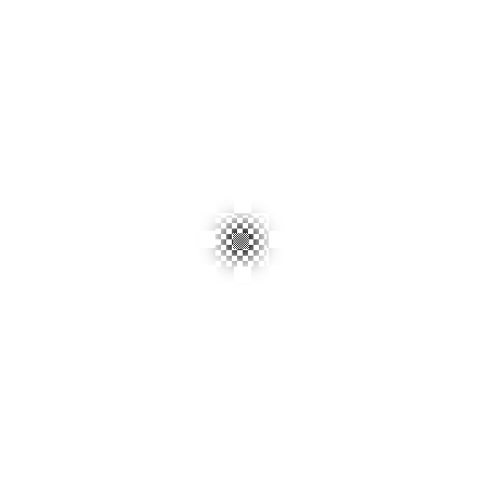

Spatial frequency 0: percentile = 1.308826895713806, number of values > percentile = 3
Spatial frequency 1: percentile = 1.347128561019898, number of values > percentile = 3
Spatial frequency 2: percentile = 2.3938860416412404, number of values > percentile = 10
Spatial frequency 3: percentile = 4.199931144714365, number of values > percentile = 41
Filter includes 57 out of 54252 filters


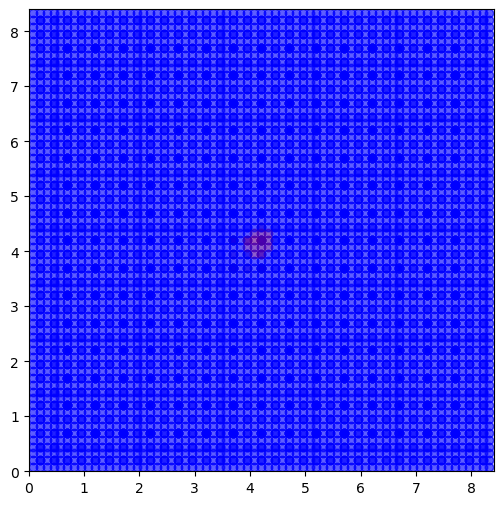

In [22]:
plaat_nummer = 1

output = gauss_output[plaat_nummer]
show(gauss_check_stack[plaat_nummer], figsize=(6,6))

n_spatfreqs = len(spat_freqs)
nth_percentile = 99.9  # Change this to your desired percentile

# normalise the output for every spatial frequency separately
from scipy.stats import zscore as zs

start = 0
circle_output_norm = []
for i in range(n_spatfreqs):
    end = start + filters_per_freq[i]
    circle_output_norm.append(zs(output[start:end]))
    start = end

# Calculate the nth percentile for each spatial frequency and create a boolean mask
# TODO: save these in a list, already kinda did so
dot_filter = []
filters_per_freq_sel = []
for i in range(n_spatfreqs):
    percentile = np.percentile(circle_output_norm[i], nth_percentile)
    mask = circle_output_norm[i] > percentile
    dot_filter.append(mask)
    n_filters = np.sum(mask)
    filters_per_freq_sel.append(n_filters)
    print(f"Spatial frequency {i}: percentile = {percentile}, number of values > percentile = {n_filters}")

dot_filter = np.concatenate(dot_filter)

filter_list = list(np.array(checkpyramid.view.filters)[dot_filter])

print(f"Filter includes {np.sum(dot_filter)} out of {checkpyramid.view.nfilters} filters")

plot_filter_locations(gabor_pyramid=checkpyramid, in_range=dot_filter, pixdims=(425, 425))

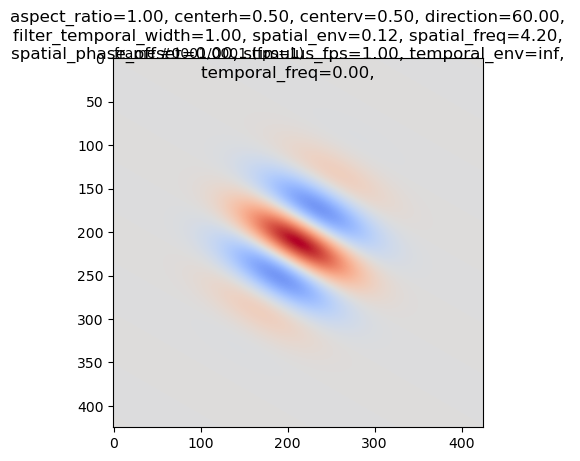

In [60]:
def show_random_filter(pyramid, filter):
    # The indices for the filters that are within the patch
    filter_indices = np.where(filter == True)[0]
    this_filter = random.choice(filter_indices)
    pyramid.view.show_filter(this_filter)
    plt.show()


show_random_filter(checkpyramid, dot_filter)

In [61]:
sel_output = checkpyramid.project(filters=filter_list)

project_stimulus: 100%|██████████| 57/57 [00:00<00:00, 70.67it/s]


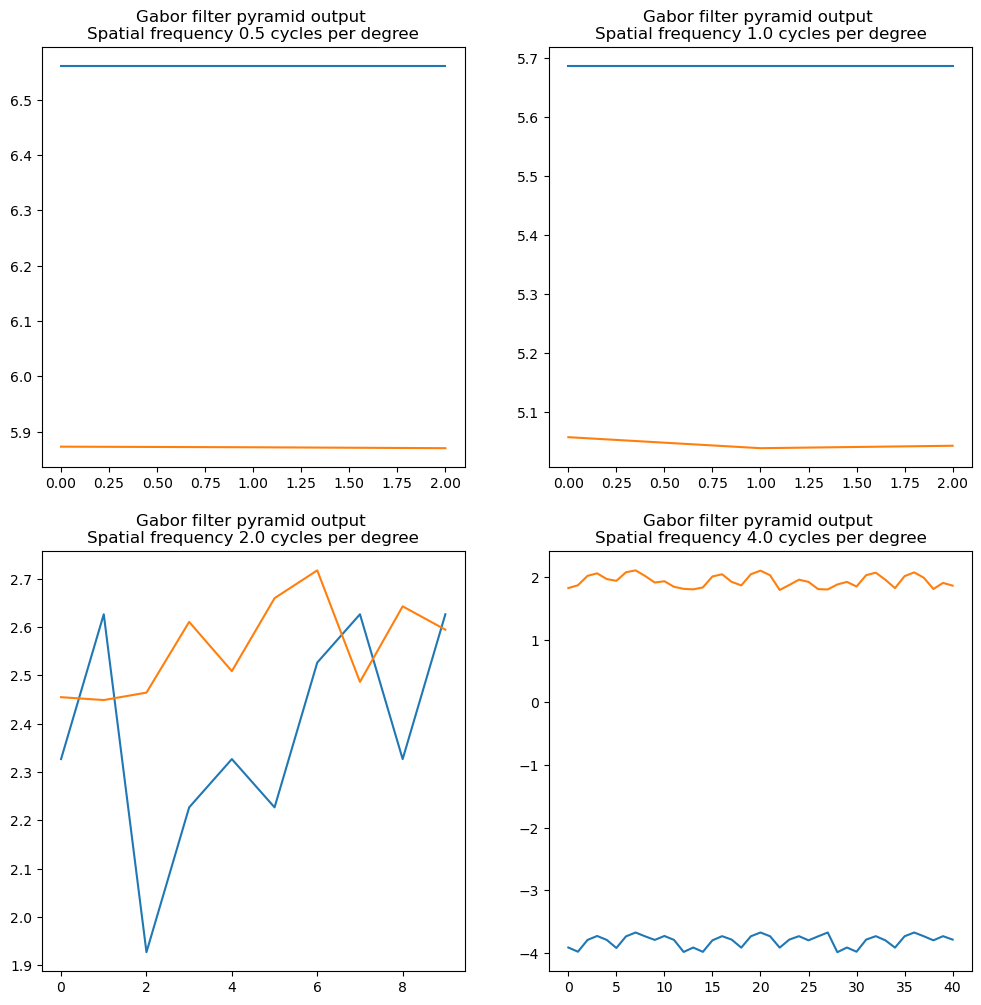

In [62]:
# Let's inspect the output for our selected filters, given the probe stimuli
# TODO: make x axis integers, as they refer to separate filters
plot_filter_outputs(sel_output=sel_output,
                    filters_per_freq_sel=filters_per_freq_sel,
                    spat_freqs=spat_freqs,
                    img_indices=[0,1])

#### Apply to the NSD

In [63]:
nsd_img_path = '/Users/wiegerscheurer/Library/CloudStorage/OneDrive-UvA/UvA/2023-2024/ResMas Thesis/Data/stimuli'
os.listdir(nsd_img_path)
img_names = os.listdir(nsd_img_path)
img_list = []

for fileno, img_name in enumerate(img_names):
    img = plt.imread(f"{nsd_img_path}/{img_name}")
    labimg = moten.colorspace.rgb2lab(img)
    lumimg = labimg[:,:,0]
    img_list.append(lumimg)

imgstack = np.array(img_list)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/wiegerscheurer/Library/CloudStorage/OneDrive-UvA/UvA/2023-2024/ResMas Thesis/Data/stimuli'

In [ ]:
nsdpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=imgstack,
                                                spatial_frequencies=[4.2, 8.4, 16.8, 33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 20)),
                                                sf_gauss_ratio=1, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=.5,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,
)

nsdpyramid.view.nfilters

In [ ]:
# nsd_output = nsdpyramid.project(filters=filter_list) # Quite fast! about .28 second per img

nsd_output = nsdpyramid.project_stimulus(imgstack, filters=filter_list)
# so that means it takes for 73000 images about 5.5 hours to run and then we have 
# 544 output dimensions instead of the 3 we have now (RMS, SC, CE)
# I could potentially even run a PCA on those 544 outputs to reduce the dimensionality even further
# However, I'm not sure how sensible that is, as gabor convolutions are already
# relatively sparse representations of the image, it depends on how good it is as a baseline
# in either case. First I need to try out it without PCA.

In [ ]:
# Wowza, look at the unique responses to 10 random NSD images, seems to work nicely.
# Even the scale seems to make some sense, but still good to zscore them.
plot_filter_outputs(
    sel_output=nsd_output,
    filters_per_freq_sel=filters_per_freq_sel,
    spat_freqs=spat_freqs,
    img_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)

### Try out some analyses

In [3]:
#@title import model class and utility functions
from unet_recon.inpainting import UNet
from PIL import Image
import glob,copy
import matplotlib.pyplot as plt
import numpy as np

from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [13]:
start_img = 0
n_imgs = 1000
imgs, _ = NSP.stimuli.rand_img_list(
    n_imgs=n_imgs,
    asPIL=False,
    add_masks=False,
    select_ices=NSP.stimuli.imgs_designmx()["subj01"][start_img : (start_img + n_imgs)],
)

In [162]:
from skimage import color

img_list = []

for img_no, img in enumerate(imgs):

    # Convert RGB image to LAB colour space
    lab_image = color.rgb2lab(imgs[img_no])

    # First channel [0] is Luminance, second [1] is green-red, third [2] is blue-yellow
    lumimg = lab_image[
        :, :, 0
    ]  # Extract the L channel for luminance values, assign to input array

    img_list.append(lumimg)

imgstack = np.array(img_list)

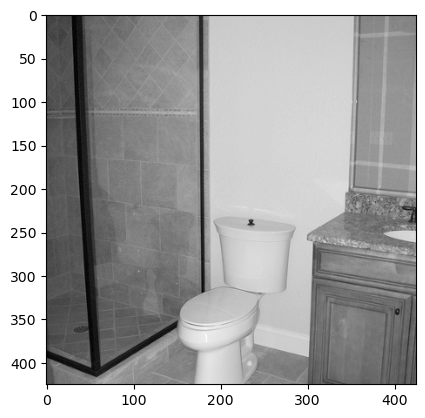

In [134]:
plt.imshow(imgstack[4], cmap='gray')

In [163]:
nsdpyramid = moten.pyramids.StimulusStaticGaborPyramid(stimulus=imgstack,
                                                spatial_frequencies=[4.2, 8.4, 16.8, 33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
                                                # spatial_orientations=(0, 45, 90, 135),
                                                spatial_orientations=tuple(range(0, 180, 20)),
                                                sf_gauss_ratio=1, # ratio of spatial frequency to gaussian s.d.
                                                max_spatial_env=(1/8.4), # max sd of gaussian envelope
                                                filter_spacing=.5,
                                                include_edges=False, # Should be false, we're not interested in the edges
                                                spatial_phase_offset=0,
)

nsdpyramid.view.nfilters

54252

In [164]:
# nsd_output = nsdpyramid.project(filters=filter_list) # Quite fast! about .28 second per img

nsd_output = nsdpyramid.project_stimulus(imgstack, filters=filter_list)
# so that means it takes for 73000 images about 5.5 hours to run and then we have 
# 544 output dimensions instead of the 3 we have now (RMS, SC, CE)
# I could potentially even run a PCA on those 544 outputs to reduce the dimensionality even further
# However, I'm not sure how sensible that is, as gabor convolutions are already
# relatively sparse representations of the image, it depends on how good it is as a baseline
# in either case. First I need to try out it without PCA.

project_stimulus: 100%|██████████| 57/57 [00:14<00:00,  3.85it/s]


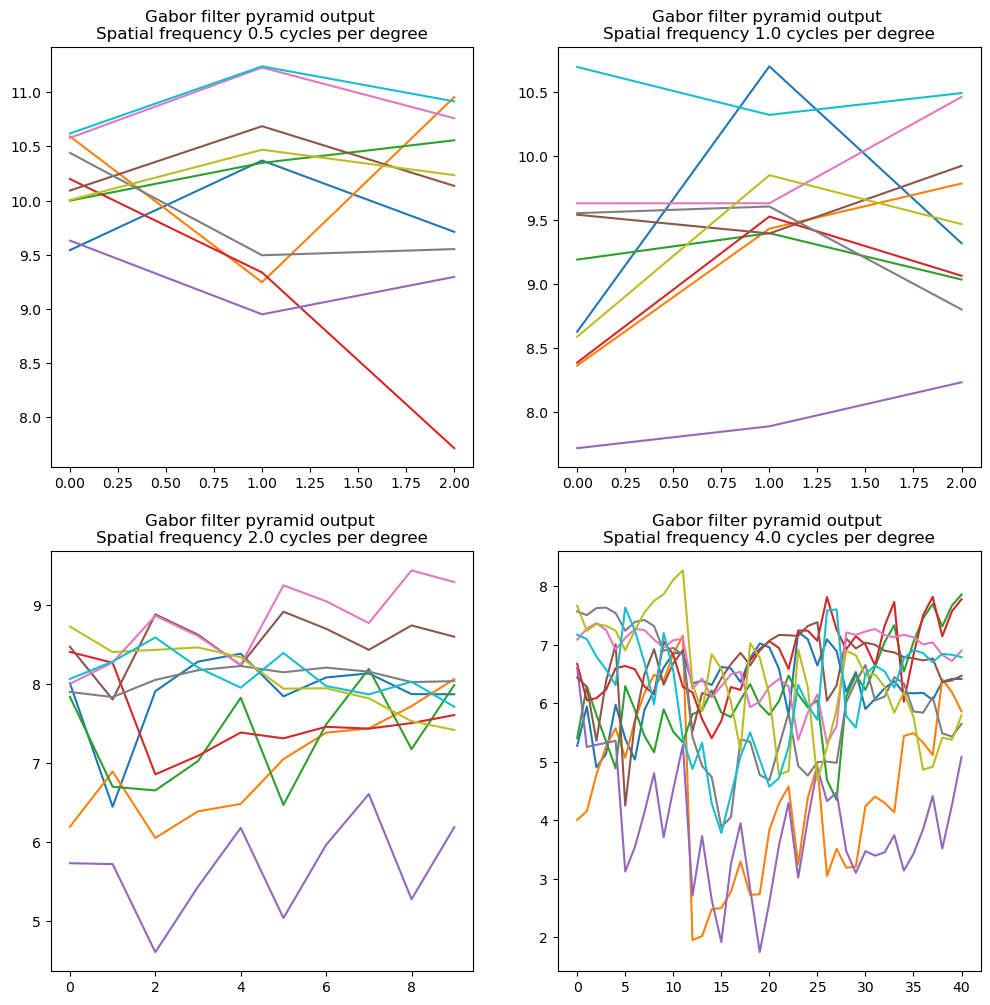

In [145]:
# Wowza, look at the unique responses to 10 random NSD images, seems to work nicely.
# Even the scale seems to make some sense, but still good to zscore them.
plot_filter_outputs(
    sel_output=nsd_output,
    filters_per_freq_sel=filters_per_freq_sel,
    spat_freqs=spat_freqs,
    img_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
)

In [3]:
nsd_output_norm = normalize_output(nsd_output, n_spatfreqs, filters_per_freq)

NameError: name 'nsd_output' is not defined

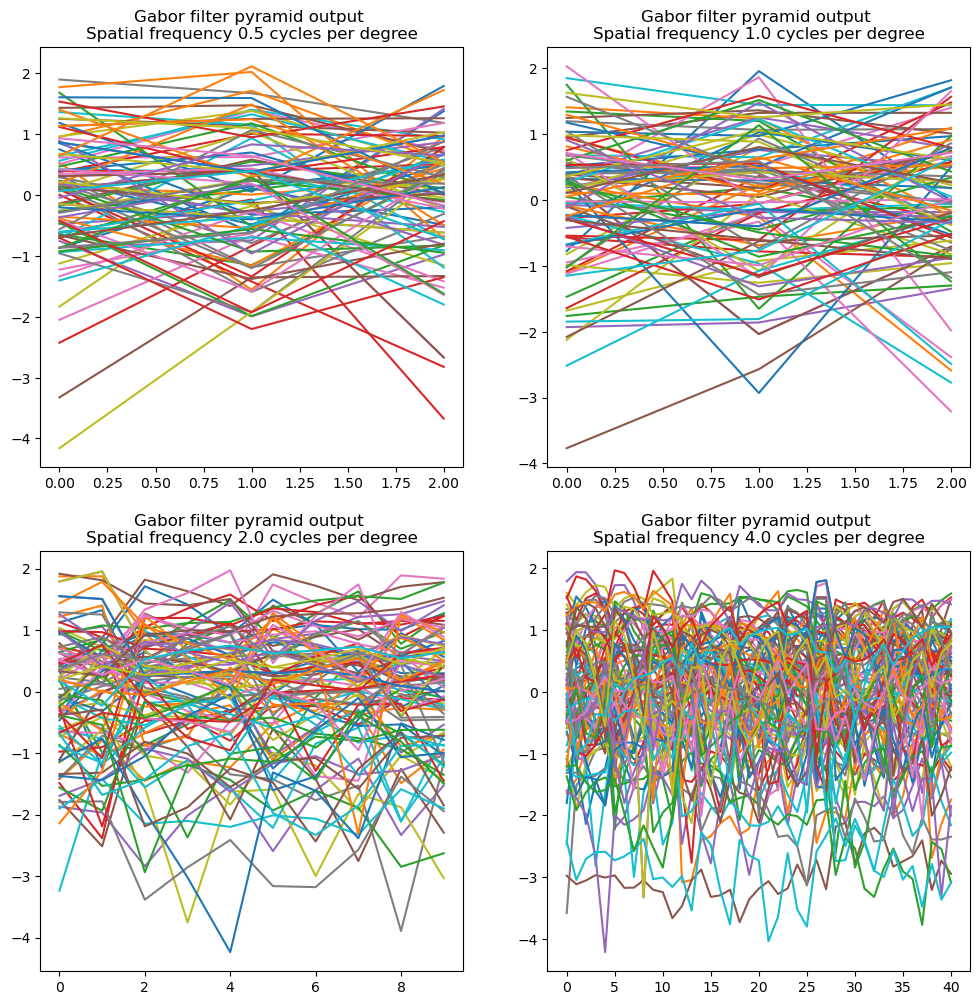

In [150]:
# Wowza, look at the unique responses to 10 random NSD images, seems to work nicely.
# Even the scale seems to make some sense, but still good to zscore them.
plot_filter_outputs(
    sel_output=nsd_output_norm,
    filters_per_freq_sel=filters_per_freq_sel,
    spat_freqs=spat_freqs,
    img_indices=list(range(0, 100)),
)

In [3]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

############ CONSTRAINED VOXEL SELECTION Y-MATRIX ################
##### ALSO RUN THIS FOR THE PRED FEATS SEPARATELY WITHOUT THE BASELINE #########

subject = "subj01"
max_size = 1
min_size = .15
# min_size = args.min_prfsize if args.min_prfsize is not None else .15 # This is for the robustness analyses
patchbound = 1
# patchbound = args.patch_radius if args.patch_radius is not None else 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170

voxeldict = {}
n_voxels = []
for roi in rois:
    print_attr = True if roi == rois[len(rois)-1] else False
    voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                subject=subject, 
                                roi=roi,
                                patchloc='central', 
                                max_size=max_size, 
                                min_size=min_size, 
                                patchbound=patchbound, 
                                min_nsd_R2=min_nsd_R2, 
                                min_prf_R2=min_prf_R2,
                                print_attributes=print_attr,
                                fixed_n_voxels=None)
    n_voxels.append(len(voxeldict[roi].size))
    
max_n_voxels = np.min(n_voxels)

ydict = {}
for roi in rois:
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=30000).T # I changed n_trials
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')


V1 voxels that fulfill requirements: 437 out of 7887.
V2 voxels that fulfill requirements: 805 out of 8296.
V3 voxels that fulfill requirements: 746 out of 7022.
V4 voxels that fulfill requirements: 538 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 437)
V2 y-matrix has dimensions: (30000, 805)
V3 y-matrix has dimensions: (30000, 746)
V4 y-matrix has dimensions: (30000, 538)


In [5]:
# FULL VISUAL CORTEX YDICT

rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

############ CONSTRAINED VOXEL SELECTION Y-MATRIX ################
##### ALSO RUN THIS FOR THE PRED FEATS SEPARATELY WITHOUT THE BASELINE #########

subject = "subj01"
max_size = 1
min_size = .15
# min_size = args.min_prfsize if args.min_prfsize is not None else .15 # This is for the robustness analyses
patchbound = 1
# patchbound = args.patch_radius if args.patch_radius is not None else 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170

voxeldict = {}
n_voxels = []
for roi in rois:
    print_attr = True if roi == rois[len(rois)-1] else False
    voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                subject=subject, 
                                roi=roi,
                                patchloc='central', 
                                max_size=max_size, 
                                min_size=min_size, 
                                patchbound=patchbound, 
                                min_nsd_R2=min_nsd_R2, 
                                min_prf_R2=min_prf_R2,
                                print_attributes=print_attr,
                                fixed_n_voxels="all")
    n_voxels.append(len(voxeldict[roi].size))
    
max_n_voxels = np.min(n_voxels)

ydict = {}
for roi in rois:
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=30000).T # I changed n_trials
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')


V1 voxels that fulfill requirements: 7887 out of 7887.
V2 voxels that fulfill requirements: 8296 out of 8296.
V3 voxels that fulfill requirements: 7022 out of 7022.
V4 voxels that fulfill requirements: 3976 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 7887)
V2 y-matrix has dimensions: (30000, 8296)
V3 y-matrix has dimensions: (30000, 7022)
V4 y-matrix has dimensions: (30000, 3976)


In [4]:
subject = "subj01"
which_cnn = "vggfull"

### THIS IS A PROBLEM, LOOK AT THE ORDER IN WHICH THE CONTENT LOSSES ARE INCLUDED, FIX THIS!!!!

Zou ook betekenen dat ik m'n analyses opnieuw moet runnen, of een scrippie schrijven die m'n files opnieuw opslaat, maar misschien ook niet, ff goed gluren hoe die unpred_feats werkt, wat ie doet. Ik denk dat het gewoon een simpele sorterings fout is, en dat de files wel in de goede volgorde zijn opgeslagen. BOvendien haalt ie deze scores uit files waarin de volgorde sowieso klopt, 't is gewoon de manier waarop ze geretrieved worden.

In [5]:
Xpred_conv = NSP.stimuli.unpred_feats(cnn_type=which_cnn, content=True, style=False, ssim=False, pixel_loss=False, 
                                 L1=False, MSE=True, verbose=True, outlier_sd_bound=5, subject=subject)[:ydict["V1"].shape[0]]

Fetched file from: all_predestims_vggfull.csv
['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'content_loss_5_MSE', 'content_loss_6_MSE', 'content_loss_7_MSE', 'content_loss_8_MSE', 'content_loss_9_MSE', 'content_loss_10_MSE', 'content_loss_11_MSE', 'content_loss_12_MSE', 'content_loss_13_MSE']


In [6]:
Xpred_dense = NSP.stimuli.unpred_feats(cnn_type=which_cnn, content=True, style=False, ssim=False, pixel_loss=False, 
                                 L1=False, MSE=True, verbose=True, outlier_sd_bound=5, subject=subject, dense=True)[:ydict["V1"].shape[0]]

Fetched file from: all_predestims_vggfull.csv
['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE']


In [7]:
Xpred = np.hstack((Xpred_conv, Xpred_dense))
Xpred.shape

(30000, 17)

In [8]:
### Inspect how this shit works, I think now:
# import the .py file
# import the function or class that needs to be updated
# importlib.reload(.py file)
# import the 

from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve
NSP = NatSpatPred()
NSP.initialise(verbose=True)
rl = Reloader()
NSP = rl.nsp()

# These are the 4 steps
import classes.stimuli
from classes.stimuli import Stimuli

importlib.reload(classes.stimuli)
from classes.stimuli import Stimuli

import classes.analysis
from classes.analysis import Analysis

importlib.reload(classes.analysis)
from classes.analysis import Analysis

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [56]:
Xgabor_sub_trial1 = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="trial1",
    verbose=False,
    fixed_subj_path="/home/rfpred/data/custom_files/visfeats/gabor_pyramid/batches_trial1/",
)
Xgabor_sub_trial2 = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="trial2",
    verbose=False,
    fixed_subj_path="/home/rfpred/data/custom_files/visfeats/gabor_pyramid/batches_trial2/",
)
Xgabor_sub_trial3 = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="trial3",
    verbose=False,
    fixed_subj_path="/home/rfpred/data/custom_files/visfeats/gabor_pyramid/batches_trial3/",
)
Xgabor_sub_trial4 = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="trial4",
    verbose=False,
    fixed_subj_path="/home/rfpred/data/custom_files/visfeats/gabor_pyramid/batches_trial4/",
)

Xgabor_sub_all_imgs = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="all_imgs",
    verbose=False,)



Xgabor_sub_all_imgs_sf4_dir6_loc_rat1p5 = NSP.stimuli.load_gabor_output(
    subject=subject,
    file_tag="trial4",
    verbose=False,
    fixed_subj_path="/home/rfpred/data/custom_files/visfeats/gabor_pyramid/batches_all_imgs_sf4_dir6_loc_rat1.5/",
)


In [53]:
import pandas as pd

Xenc = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/encoding/VGG_lay0_regdf.csv")
Xenc

x   y   z roi         R  R_alt_model   delta_r     betas  \
0       55   7  77  V1  0.037789     0.007931  0.029858 -0.000202   
1       55  11  75  V1  0.005652     0.001296  0.004356  0.000083   
2       56   7  76  V1  0.038227     0.008932  0.029295  0.000057   
3       56   7  77  V1  0.022830     0.005175  0.017655 -0.000002   
4       56   7  78  V1  0.021766     0.000872  0.020894 -0.000050   
...    ...  ..  ..  ..       ...          ...       ...       ...   
27176  114  28  65  V4  0.007910    -0.007813  0.015723  0.000164   
27177  114  28  66  V4  0.013153    -0.008719  0.021872  0.000239   
27178  114  29  62  V4  0.004790     0.007981 -0.003191 -0.000168   
27179  115  28  64  V4 -0.013360     0.010105 -0.023465  0.000230   
27180  115  28  65  V4 -0.002486    -0.005283  0.002798 -0.000048   

       betas_alt_model  beta_unpred  
0            -0.000107    -0.002336  
1             0.000041     0.003024  
2             0.000071    -0.005401  
3             0.000001    -0.007409  
4            -0.000096    -0.011492  
...                ...          ...  
27176        -0.000106    -0.013536  
27177        -0.000040     0.006028  
27178        -0.000309    -0.012470  
27179        -0.000362    -0.014794  
27180         0.000258    -0.002155  

[27181 rows x 10 columns]

In [66]:
# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir6', verbose=False) # Dit was m eerst
# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir6_ecc2.0_angle330', verbose=False)[:ydict["V1"].shape[0]] 
# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag="all_imgs_sf4_dir9", verbose=True)[:ydict["V1"].shape[0]] # This is the non-lenient one 
# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag="all_imgs_sf4_dir6_loc", verbose=True)
# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag="all_imgs_sf4_dir6_loc_rat1.5", verbose=True)
Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag="all_imgs_sf5_dir9_loc_rat.6", verbose=True)

# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag="all_imgs", verbose=True)

Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.60_1000.npy
Batch 0 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.61000_2000.npy
Batch 1 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.62000_3000.npy
Batch 2 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.63000_4000.npy
Batch 3 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.64000_5000.npy
Batch 4 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.65000_6000.npy
Batch 5 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.66000_7000.npy
Batch 6 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.67000_8000.npy
Batch 7 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.68000_9000.npy
Batch 8 shape: (1000, 643)
Processing file: gabor_baseline_all_imgs_sf5_dir9_loc_rat.69000_10000.npy
Batch 9 shape: (1000, 643)
Pr

In [67]:
# print(Xgabor.shape)
print(Xgabor_sub.shape)

(30000, 643)


### Old baseline

In [21]:
import pandas as pd

rms = np.array(NSP.stimuli.get_rms(subject)[:ydict["V1"].shape[0]])
sc = np.array(NSP.stimuli.get_scce(subject, 'sc')[:ydict["V1"].shape[0]])
ce = np.array(NSP.stimuli.get_scce(subject, 'ce')[:ydict["V1"].shape[0]])
# baseline = pd.concat([rms, sc, ce], axis=1)[:ydict["V1"].shape[0]]

baseline = np.hstack((rms, sc, ce))
baseline.shape


Xbaseline = np.hstack((baseline, Xgabor_sub))

Xbaseline.shape

(30000, 2009)

### Mean unpredictability matrix

In [88]:
Xpred_mean = np.mean(Xpred, axis=1).reshape(-1,1)
Xpred_mean.shape

(24000, 1)

### Convolutional layer feature map from VGG16

In [128]:
Xconv3 = NSP.stimuli.alex_featmaps(layers=[17], subject=subject, smallpatch=True, modeltype="VGG")[:ydict["V1"].shape[0],:100] # is zscored

Xconv3.shape

(24000, 100)

### THe actual analysis block

In [12]:
range(0, 10)[:2]

range(0, 2)

Xpred has these dimensions: (30000, 17)
X has these dimensions: (30000, 644)


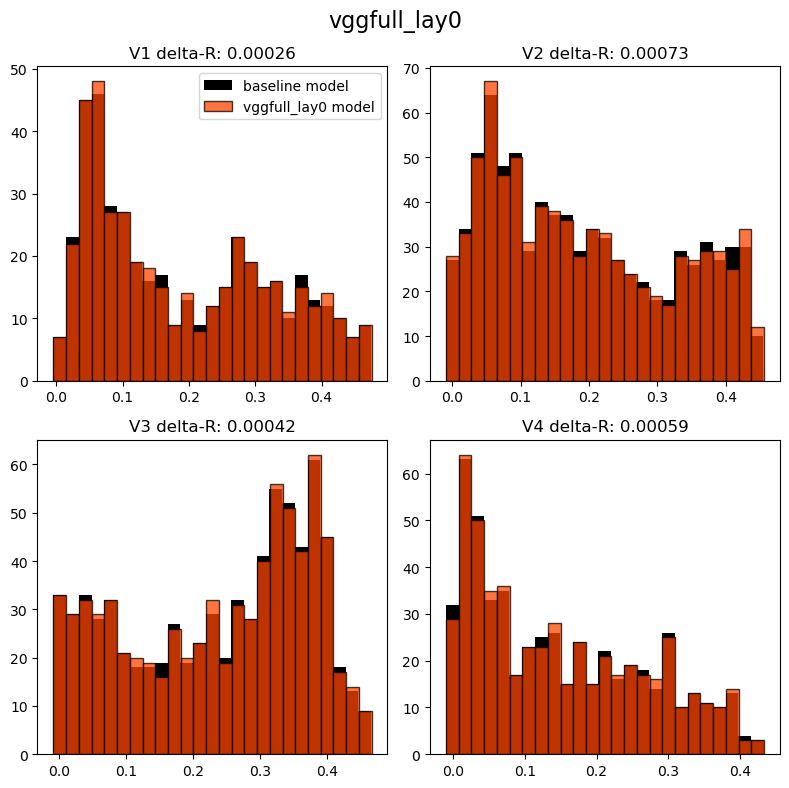

X has these dimensions: (30000, 644)


<Figure size 640x480 with 0 Axes>

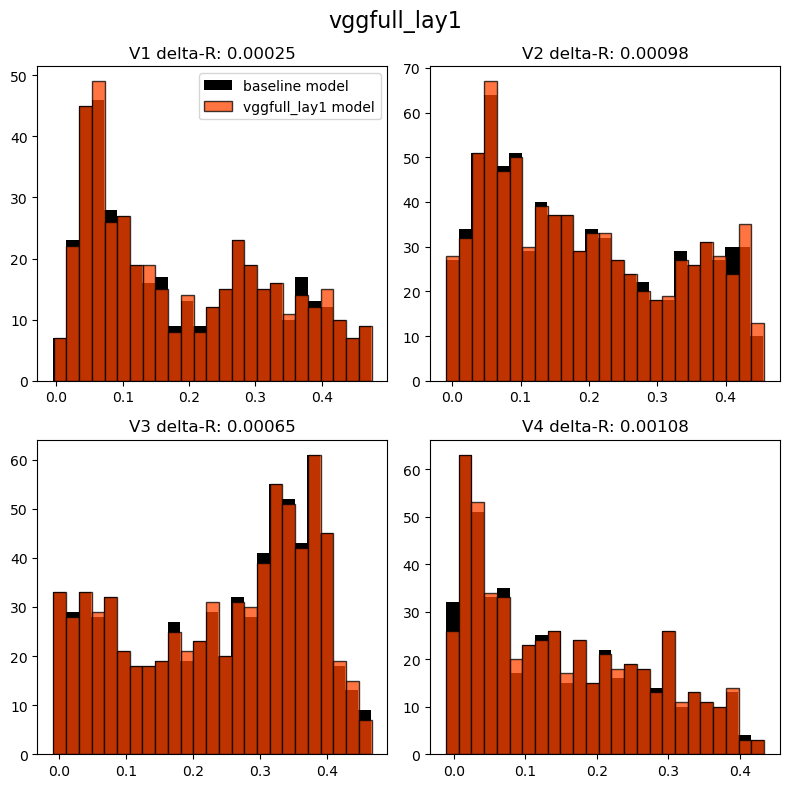

<Figure size 640x480 with 0 Axes>

In [69]:
Xbl = Xgabor_sub
# Xbl = X_pca
# Xbl = rms
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
for layer in range(start_idx, Xpred.shape[1])[:2]:
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=True,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_sf5_dir9_loc_rat.6_pca',
                             X_str=f'{feat} model')


In [13]:
Xbl.shape

(30000, 2006)

### Dimensionality reduction of the gabor pyramid baseline model to check whether this is sensible

In [51]:
from sklearn.decomposition import PCA

# Initialize a PCA object. You can specify the number of components you want to keep.
# For example, to keep the top 10 components:
pca = PCA(n_components=20)

# Fit the PCA model to your data and apply the dimensionality reduction
X_pca = pca.fit_transform(Xgabor_sub)

# X_pca now contains the top 10 principal components of your data


In [48]:
X_pca.shape

(30000, 20)

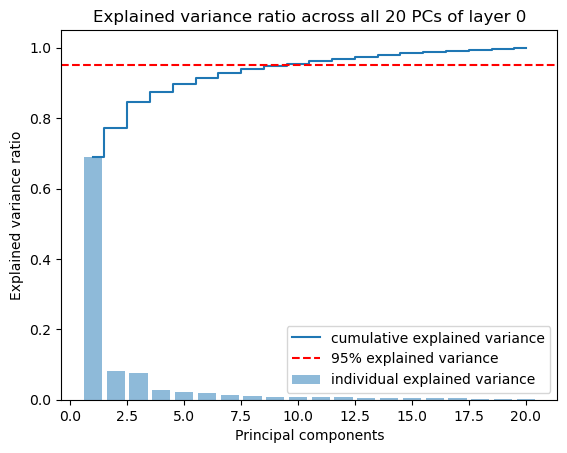

In [49]:
NSP.utils.explained_var_plot(relu_layer=0, n_pcs =20, manual_pca=pca)

## Stacked analyses for comparison 

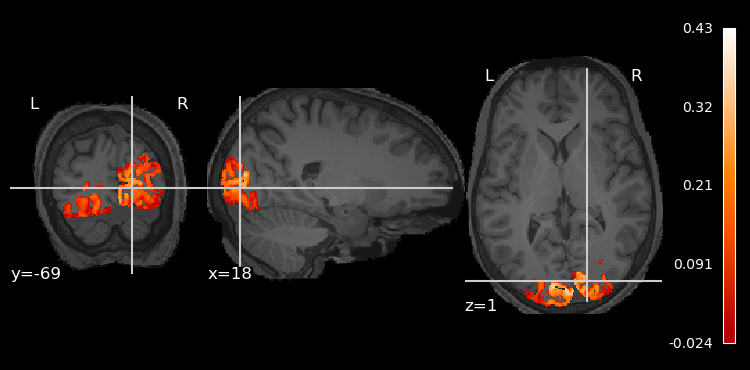

Xpred has these dimensions: (30000, 17)
X has these dimensions: (30000, 1927)


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.20066e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.0264e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.11357e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.05885e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/rfpred/envs/rfenv/lib/python3.1

KeyboardInterrupt: 

In [57]:
# Xbl = Xgabor_sub
# Xbl = Xconv3

xyz = Xenc.iloc[:, :3].to_numpy().astype(int)
baseline_r = np.array(Xenc["R"]).reshape(-1, 1)
delta_r = np.array(Xenc["delta_r"]).reshape(-1, 1)

baseline_brain = NSP.utils.coords2numpy(
    np.hstack((xyz, baseline_r)),
    shape=roi_masks[subject]["V1_mask"].shape,
    keep_vals=True,
)
NSP.analyse.plot_brain(
    prf_dict, rois, "subj01", baseline_brain, cmap="gist_heat", glass_brain=False
)


for Xbl in [
    Xgabor_sub_all_imgs,
    Xgabor_sub_trial1,
    Xgabor_sub_trial2,
    Xgabor_sub_trial3,
    Xgabor_sub_trial4,
    Xgabor_sub_all_imgs_sf4_dir6_loc_rat1p5
]:
    start_idx = 0  # Set to 14 for dense layer only
    n_layers = Xpred.shape[1]

    print(f"Xpred has these dimensions: {Xpred.shape}")

    # for layer in range(start_idx, Xpred.shape[1]):
    layer = 0
    feat = f"{which_cnn}_lay{layer}"
    X_predfeat = Xpred[:, layer].reshape(-1, 1)
    X = np.hstack((Xbl, X_predfeat))
    print(f"X has these dimensions: {X.shape}")
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)

    reg_df = NSP.analyse.analysis_chain_slim(
        subject=subject,
        ydict=ydict,
        voxeldict=voxeldict,
        X=X,
        alpha=0.1,
        cv=5,
        rois=rois,
        X_alt=Xbl,  # The baseline model
        fit_icept=False,
        save_outs=True,
        regname=feat,
        plot_hist=True,
        alt_model_type="baseline model",
        save_folder=f"unpred/{which_cnn}_CHECK",
        X_str=f"{feat} model",
    )

    xyz = reg_df.iloc[:, :3].to_numpy().astype(int)
    baseline_r = np.array(reg_df["R_alt_model"]).reshape(-1, 1)
    delta_r = np.array(reg_df["delta_r"]).reshape(-1, 1)

    baseline_brain = NSP.utils.coords2numpy(
        np.hstack((xyz, baseline_r)),
        shape=roi_masks[subject]["V1_mask"].shape,
        keep_vals=True,
    )
    NSP.analyse.plot_brain(
        prf_dict, rois, "subj01", baseline_brain, cmap="gist_heat", glass_brain=False
    )

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms_from_df(df: pd.DataFrame, statistic: str, rois: list, alt_model_type: str, save_path: str = None):
    """Function to plot histograms of a given statistic and the corresponding r_uninformative for each ROI.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - statistic (str): The name of the column in df to use as r_values.
    - rois (list): The list of regions of interest (ROIs) to analyse.
    - alt_model_type (str): The name of the alternative model.
    - save_path (str, optional): The path to save the plot. If None, the plot is not saved. Defaults to None.
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()  # Flatten the axs array for easy iteration

    for i, roi in enumerate(rois[:4]):
        # Filter the DataFrame for the current ROI
        df_roi = df[df['roi'] == roi]

        # Underlay with the histogram of r_uninformative values
        axs[i].hist(df_roi['R_alt_model'], bins=25, edgecolor=None, alpha=1, label=alt_model_type, color='black')

        # Plot the histogram of the given statistic values in the i-th subplot
        axs[i].hist(df_roi[statistic], bins=25, edgecolor='black', alpha=0.75, label=statistic, color='orangered')

        this_delta_r = round(np.mean(df_roi[statistic]) - np.mean(df_roi['R_alt_model']), 5)
        axs[i].set_title(f'{roi} delta-R: {this_delta_r}')
        axs[i].legend() if roi == 'V1' else None

    plt.suptitle(f'{statistic} Histograms', fontsize=16)
    plt.tight_layout()
    plt.show()

    if save_path is not None:
        plt.savefig(f'{save_path}/{statistic}_plot.png')

In [59]:
df_3sf = pd.read_csv('/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_GABORTEST_3sf/vggfull_lay1_regdf.csv')
df_4sf = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_GABORTEST_4sf/vggfull_lay0_regdf.csv")
df_4sf_6dir = pd.read_csv("data/custom_files/subj01/results/unpred/vggfull_GABORTEST_4sf_6dir/vggfull_lay0_regdf.csv")
df_4sf_8dir = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_GABORTEST_4sf_8dir/vggfull_lay0_regdf.csv")
df_smallrfs = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_GABORTESTsmallrfs/vggfull_lay0_regdf.csv")
df_4sf_6dir_loc = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_sf4_dir6_loc/vggfull_lay0_regdf.csv")
df_4sf_6dir_loc_pca = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_sf4_dir6_loc_pca/vggfull_lay0_regdf.csv")

df_4sf_6dir_loc_pca = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull_sf4_dir6_loc_rat1.5_pca/vggfull_lay0_regdf.csv")

og_baseline = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/unpred/vggfull/vggfull_lay5_regdf.csv")
vgg_lay1 = pd.read_csv("/home/rfpred/data/custom_files/subj01/results/encoding/VGG_lay2_regdf.csv")

In [62]:
import pandas as pd

# Add a 'source' column to each dataframe
df_3sf['source'] = '3sf'
df_4sf['source'] = '4sf'
df_4sf_6dir['source'] = '4sf_6dir'
df_4sf_8dir['source'] = '4sf_8dir'
df_smallrfs['source'] = 'smallrfs'
df_4sf_6dir_loc["source"] = "df_4sf_6dir_loc"
df_4sf_6dir_loc_pca["source"] = "df_4sf_6dir_loc_pca"
og_baseline["source"] = "og_baseline"
df_4sf_6dir_loc_pca["source"]= "df_4sf_6dir_loc_pca"
vgg_lay1["source"] = "vgg_lay1"


# Concatenate the dataframes
# df = pd.concat([df_3sf, df_4sf, df_4sf_6dir, df_4sf_8dir, df_smallrfs, df_4sf_6dir_loc, df_4sf_6dir_loc_pca, df_4sf_6dir_loc_pca, og_baseline, vgg_lay1])
df = pd.concat([df_smallrfs, df_4sf_6dir_loc, df_4sf_6dir_loc_pca, df_4sf_6dir_loc_pca, og_baseline, vgg_lay1])



/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


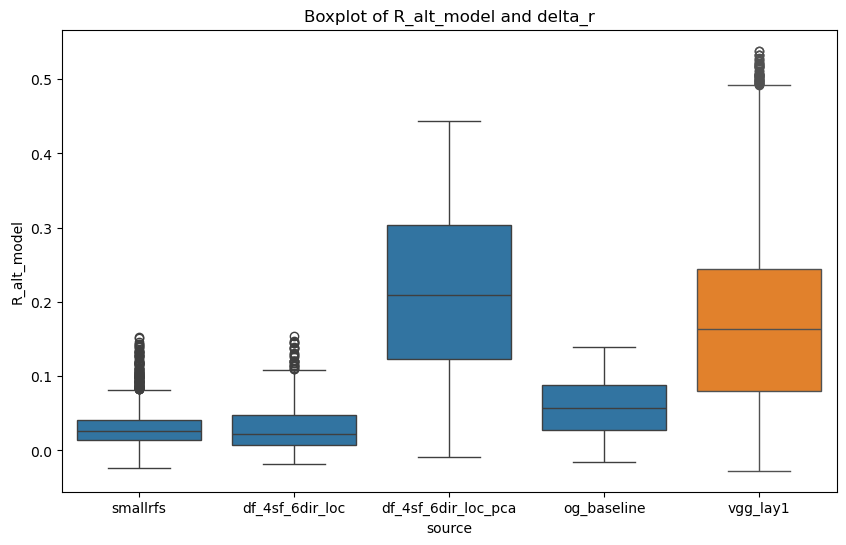

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site

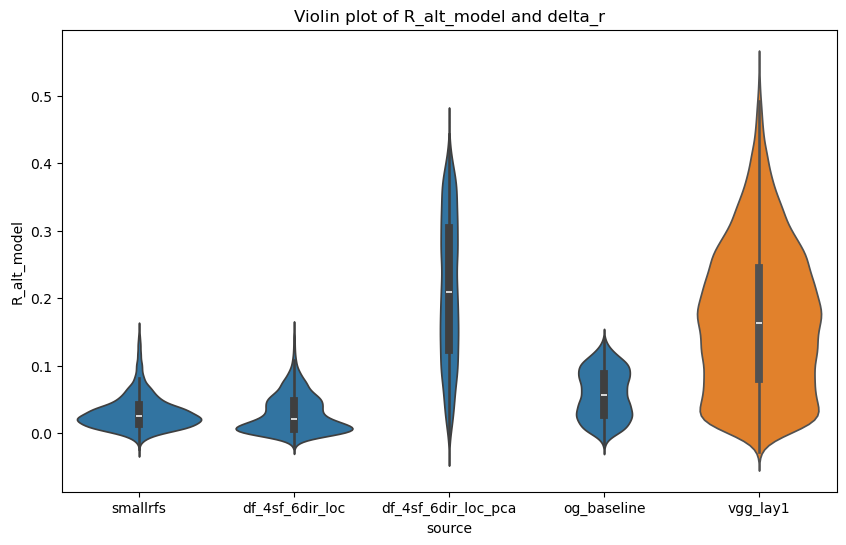

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site

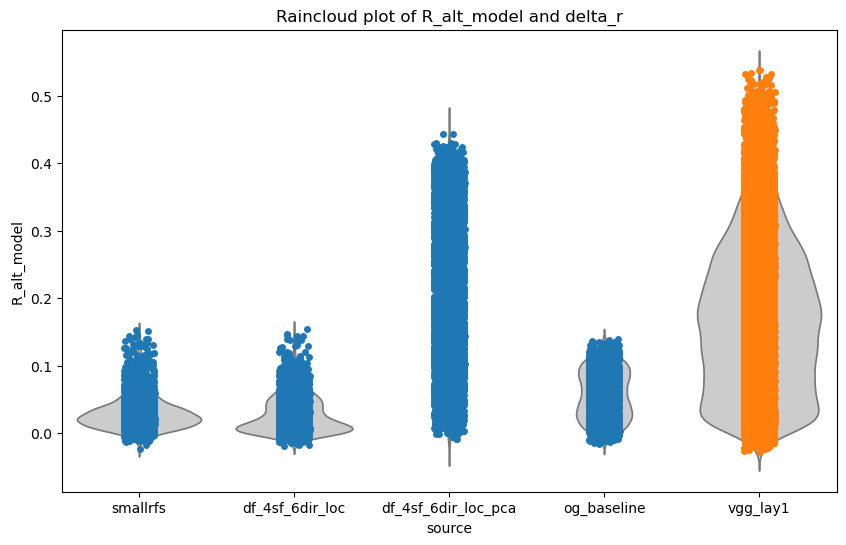

In [63]:
# Create two dataframes: one for 'vgg_lay1' and another for the rest
df_vgg_lay1 = df[df['source'] == 'vgg_lay1']
df_rest = df[df['source'] != 'vgg_lay1']

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='R_alt_model', data=df_rest)
sns.boxplot(x='source', y='delta_r', data=df_vgg_lay1)
plt.title('Boxplot of R_alt_model and delta_r')
plt.show()

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='source', y='R_alt_model', data=df_rest)
sns.violinplot(x='source', y='delta_r', data=df_vgg_lay1)
plt.title('Violin plot of R_alt_model and delta_r')
plt.show()

# Raincloud plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='source', y='R_alt_model', data=df_rest, inner=None, color=".8")
sns.stripplot(x='source', y='R_alt_model', data=df_rest)
sns.violinplot(x='source', y='delta_r', data=df_vgg_lay1, inner=None, color=".8")
sns.stripplot(x='source', y='delta_r', data=df_vgg_lay1)
plt.title('Raincloud plot of R_alt_model and delta_r')
plt.show()

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


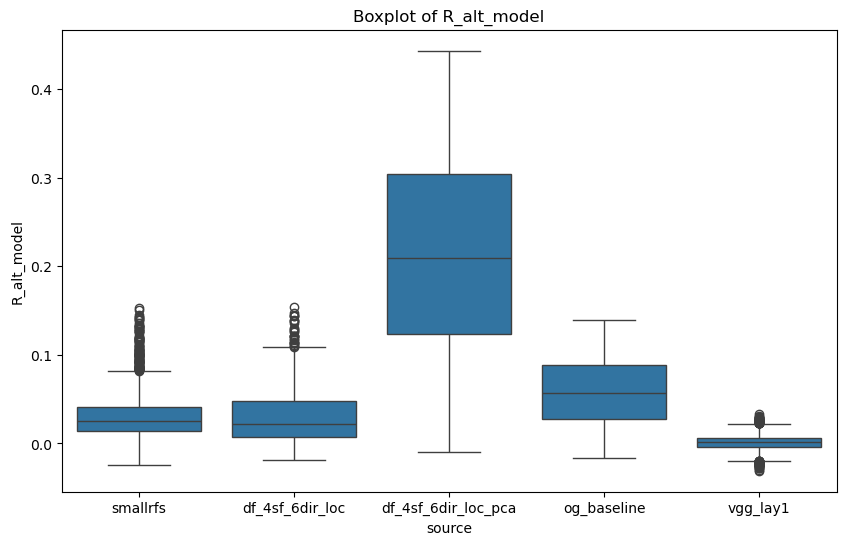

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site

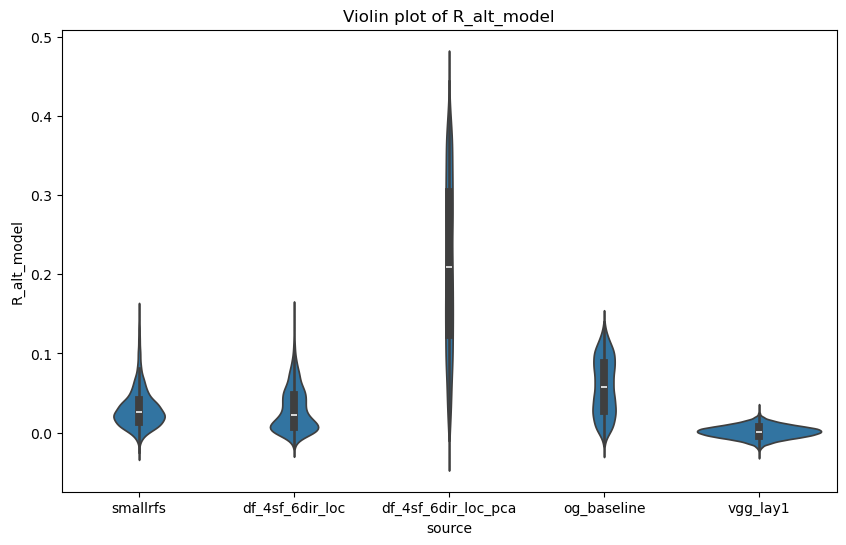

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/rfpred/envs/rfenv/lib/python3.11/site

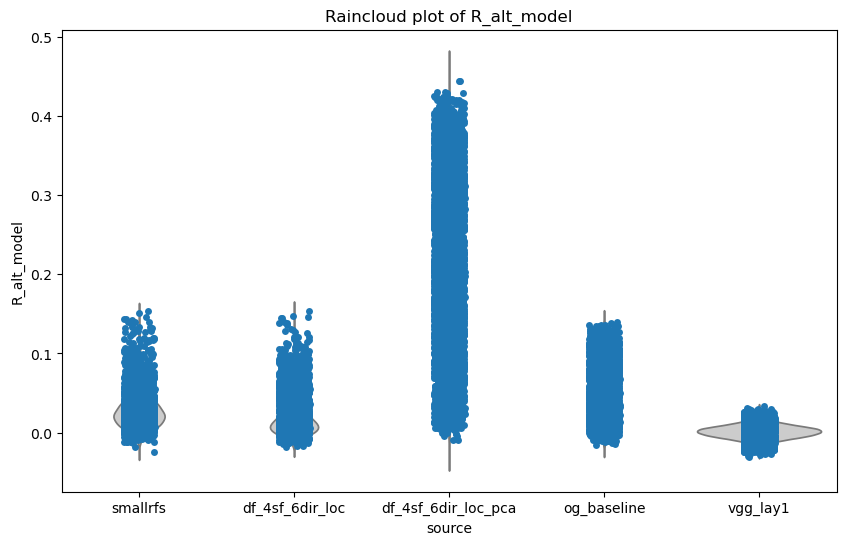

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='R_alt_model', data=df)
plt.title('Boxplot of R_alt_model')
plt.show()

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='source', y='R_alt_model', data=df)
plt.title('Violin plot of R_alt_model')
plt.show()

# Raincloud plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='source', y='R_alt_model', data=df, inner=None, color=".8")
sns.stripplot(x='source', y='R_alt_model', data=df)
plt.title('Raincloud plot of R_alt_model')
plt.show()

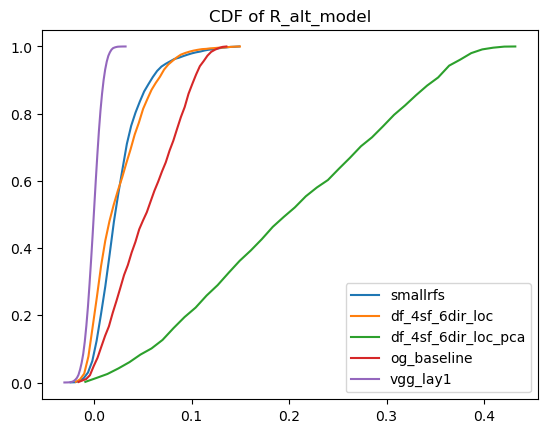

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Compute CDF for each source
for source in df['source'].unique():
    data = df[df['source'] == source]['R_alt_model']
    values, base = np.histogram(data, bins=40)
    cumulative = np.cumsum(values) / np.sum(values)
    plt.plot(base[:-1], cumulative, label=source)

plt.legend()
plt.title('CDF of R_alt_model')
plt.show()

In [30]:
# compare the baseline performance of all of them in one plot

df_3sf["R_alt_model"]

0       0.035257
1       0.024570
2       0.025266
3       0.026041
4       0.034229
          ...   
2521    0.015288
2522   -0.018787
2523    0.027019
2524    0.019878
2525    0.010288
Name: R_alt_model, Length: 2526, dtype: float64

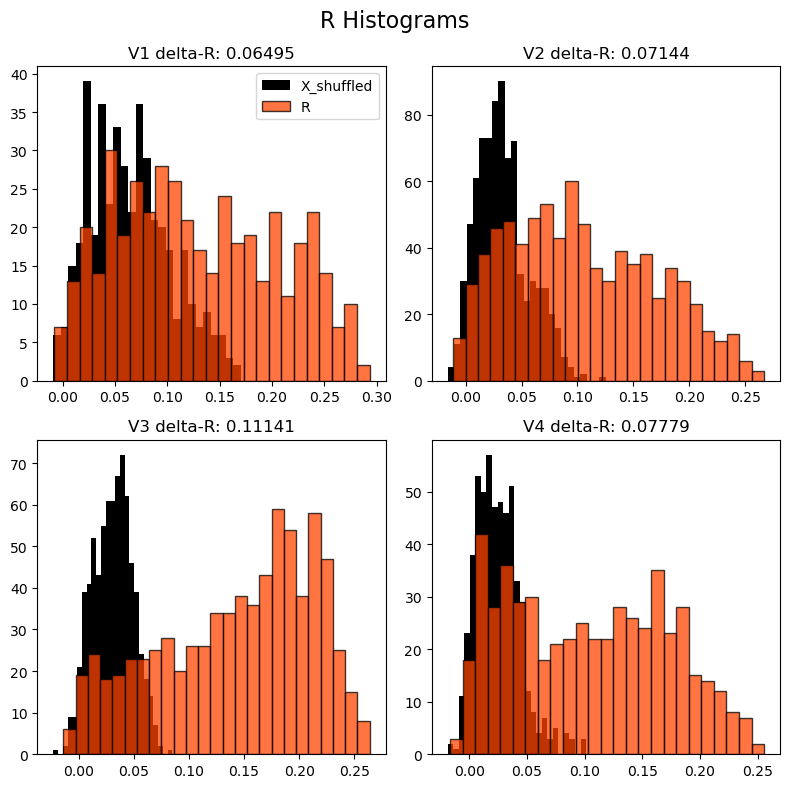

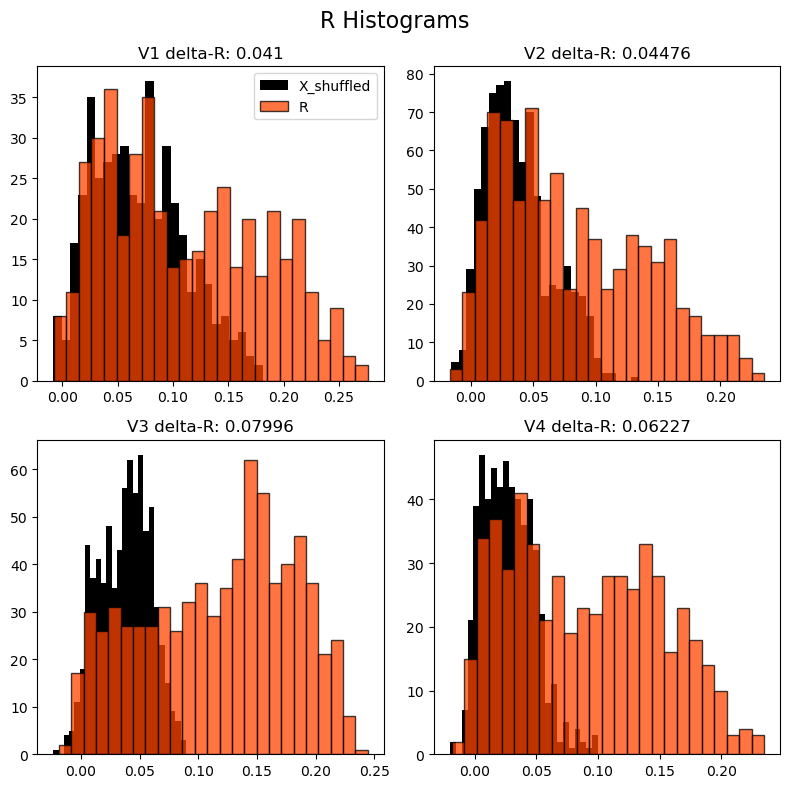

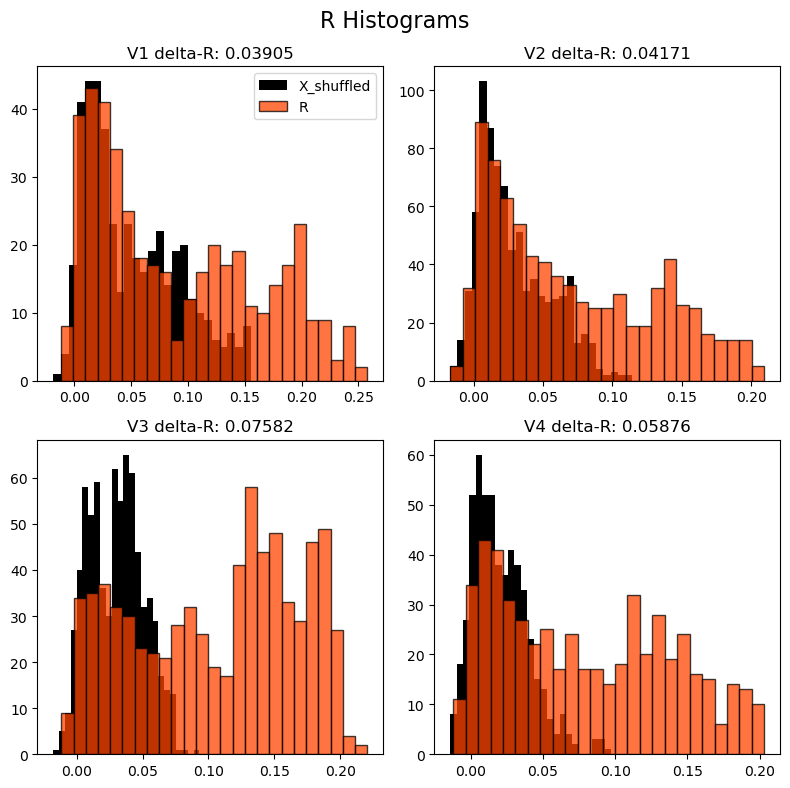

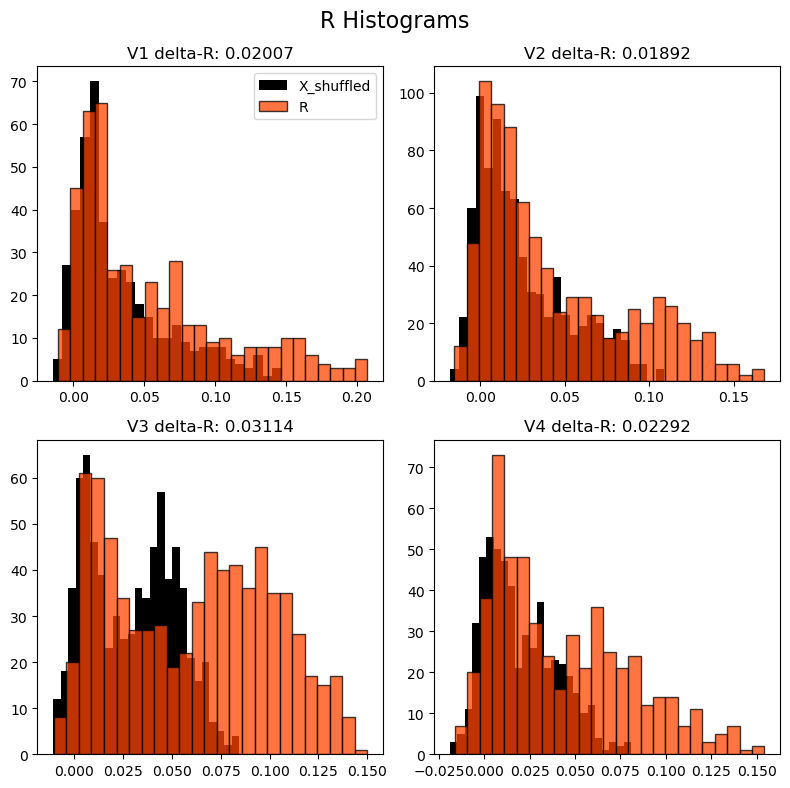

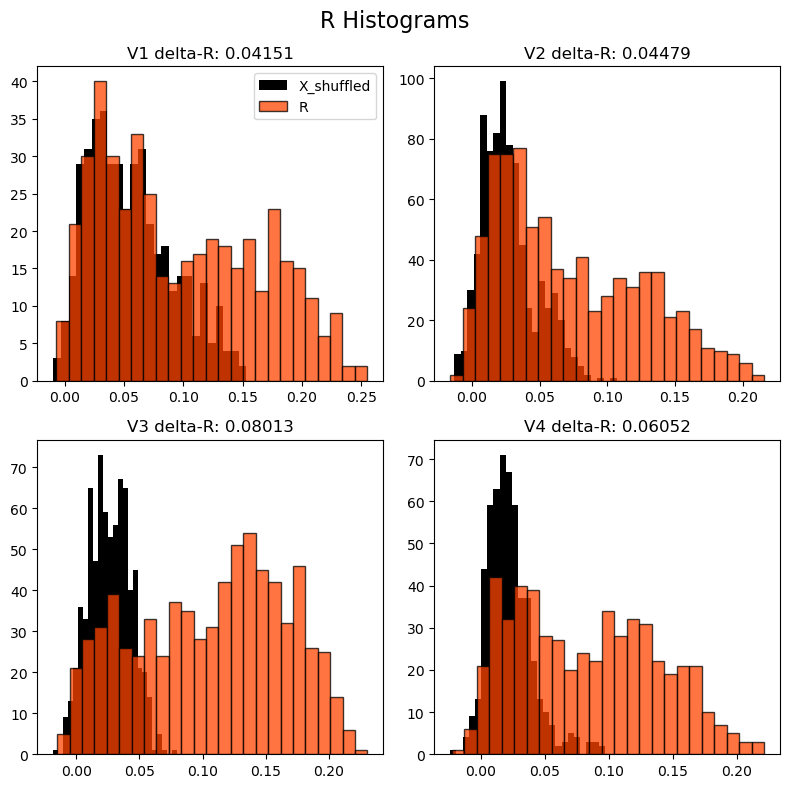

In [28]:
# Check out their regression histograms
plot_histograms_from_df(df_3sf, 'R', ['V1', 'V2', 'V3', 'V4'], 'X_shuffled')
plot_histograms_from_df(df_4sf, 'R', ['V1', 'V2', 'V3', 'V4'], 'X_shuffled')
plot_histograms_from_df(df_4sf_6dir, 'R', ['V1', 'V2', 'V3', 'V4'], 'X_shuffled')
plot_histograms_from_df(df_4sf_8dir, 'R', ['V1', 'V2', 'V3', 'V4'], 'X_shuffled')
plot_histograms_from_df(df_smallrfs, 'R', ['V1', 'V2', 'V3', 'V4'], 'X_shuffled')

# PLOT A BRAIN


In [176]:
xyz = reg_df.iloc[:,:3].to_numpy().astype(int)
print(reg_df.keys())
baseline_r = np.array(reg_df["R_alt_model"]).reshape(-1,1)
delta_r = np.array(reg_df["delta_r"]).reshape(-1,1)

Index(['x', 'y', 'z', 'roi', 'R', 'R_alt_model', 'delta_r', 'betas',
       'betas_alt_model', 'beta_unpred'],
      dtype='object')


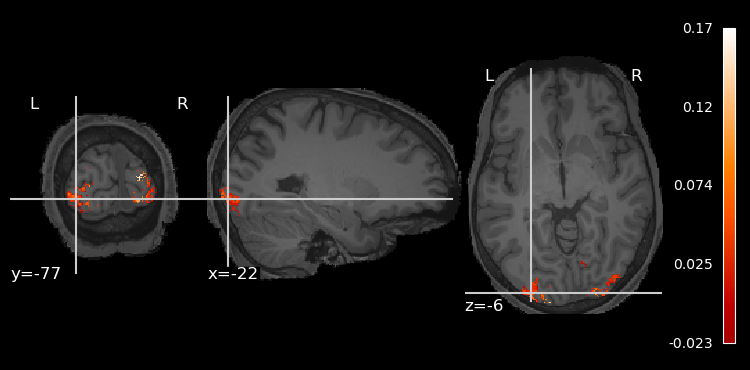

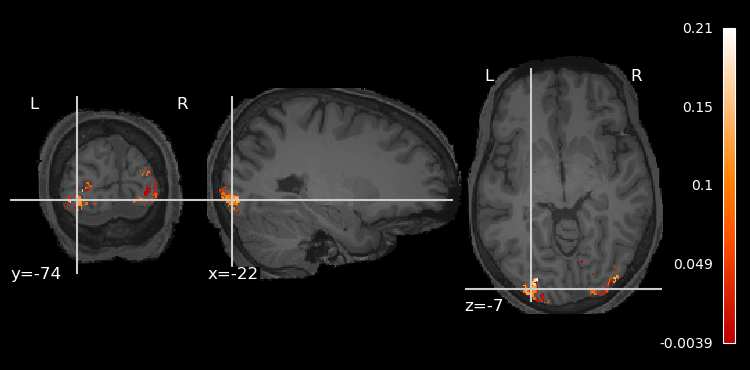

In [179]:
baseline_brain = NSP.utils.coords2numpy(
    np.hstack((xyz, baseline_r)),
    shape=roi_masks[subject]["V1_mask"].shape,
    keep_vals=True,
)

unpred_brain = NSP.utils.coords2numpy(
    np.hstack((xyz, delta_r)),
    shape=roi_masks[subject]["V1_mask"].shape,
    keep_vals=True,
)

NSP.analyse.plot_brain(
    prf_dict, rois, "subj01", baseline_brain, cmap="gist_heat", glass_brain=False
)

NSP.analyse.plot_brain(
    prf_dict, rois, "subj01", unpred_brain, cmap="gist_heat", glass_brain=False
)
# NSP.analyse.stat_on_brain(prf_dict, rois, "subj01", stat.reshape(-1,1), xyz, glass_brain=False, cmap="inferno")

Xpred has these dimensions: (30000, 17)
X has these dimensions: (30000, 236)


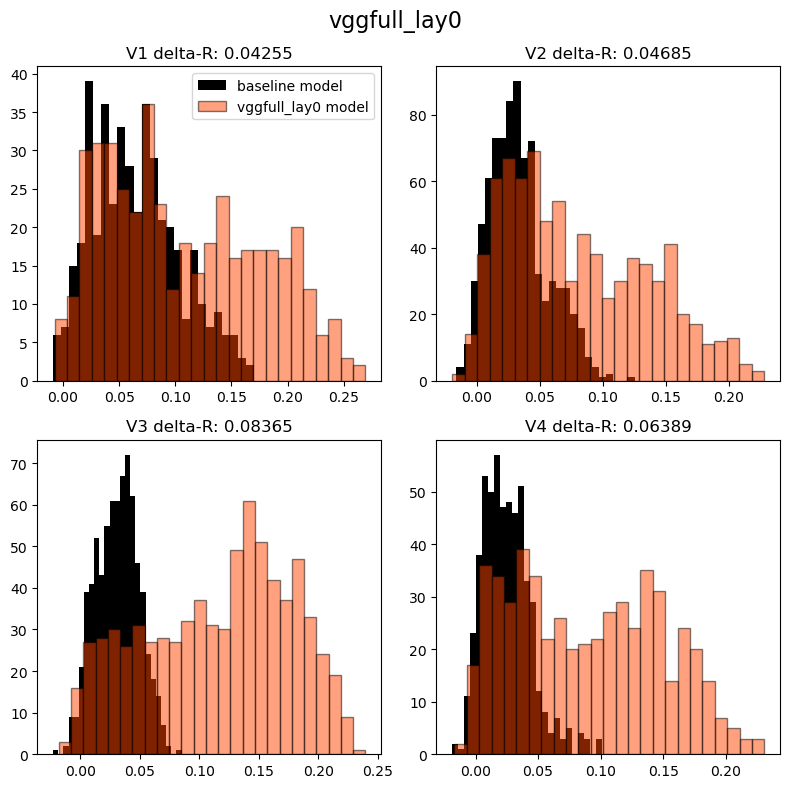

X has these dimensions: (30000, 236)


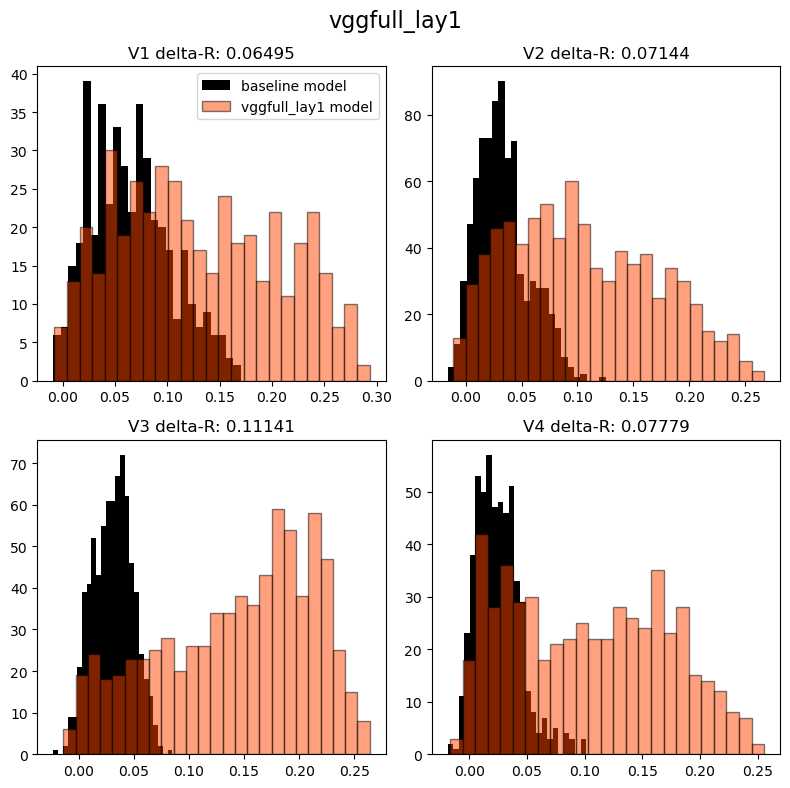

X has these dimensions: (30000, 236)


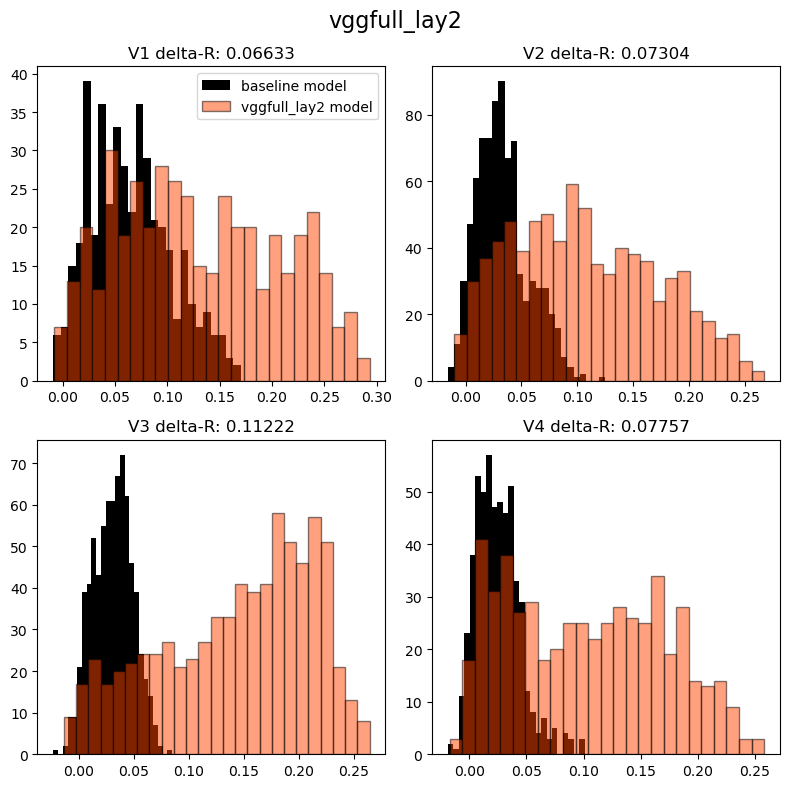

X has these dimensions: (30000, 236)


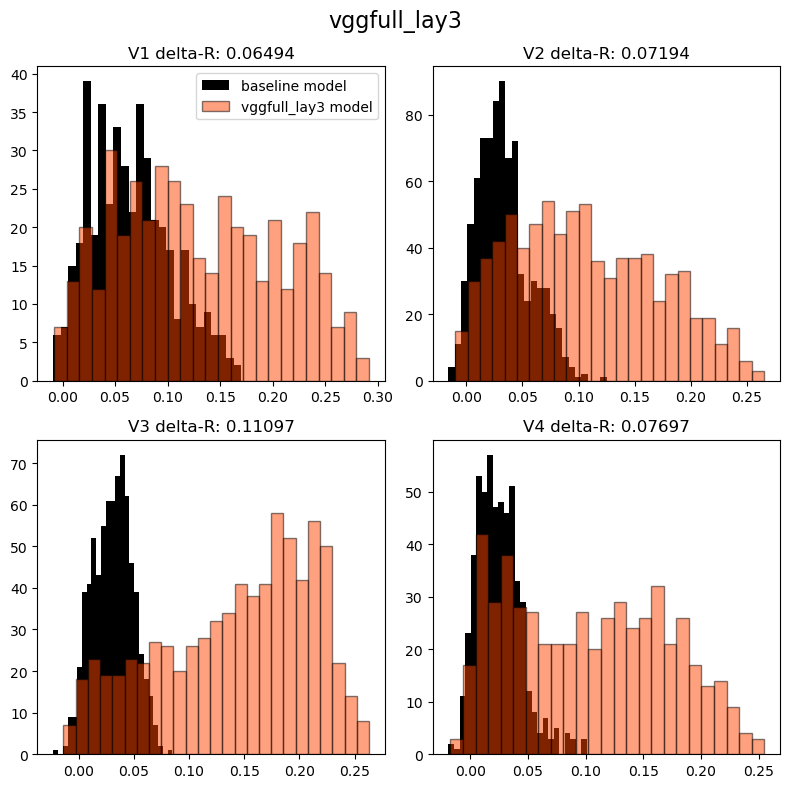

X has these dimensions: (30000, 236)


KeyboardInterrupt: 

In [112]:
Xbl = Xgabor_sub
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
for layer in range(start_idx, Xpred.shape[1]):
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=False,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_KONTGAT',
                             X_str=f'{feat} model')


Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.
Number of layers: 16


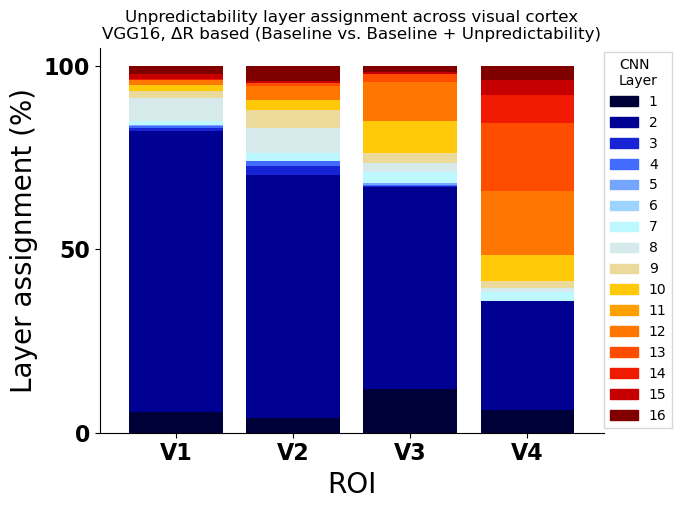

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


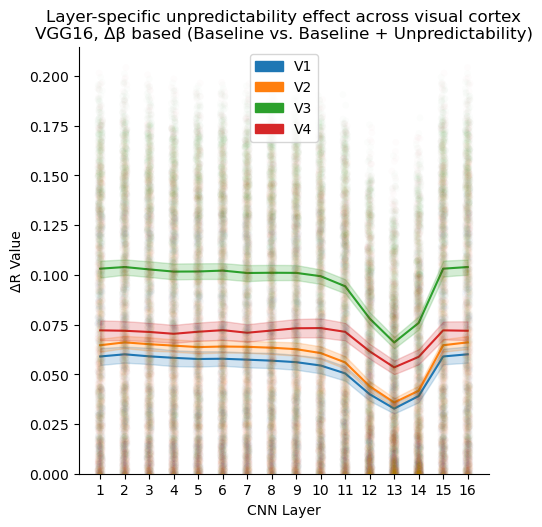

In [11]:
from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve

rd = RegData
rl = Reloader

for subject in NSP.subjects[:1]:
    vgg18results = rd(subject=subject, folder="unpred/vggfull_GABORTEST_4sf_6dir", model="vggfull", statistic="delta_r", verbose=False, skip_norm_lay = True) # Norm layer is not in the encoding featmaps (i think)
    vgg18results.df
    vgg18results.assign_layers(max_or_weighted="max",
                            verbose=True,
                            title="Unpredictability layer assignment across visual cortex\nVGG16, ΔR based (Baseline vs. Baseline + Unpredictability)",
                            #   figsize = (6 , 5.5))
                            figsize = (6.5 , 5))



    vgg18results.mean_lines(fit_polynom = False,
                polynom_order = 4,
                verbose = True,
                plot_catplot = True,
                title = "Layer-specific unpredictability effect across visual cortex\nVGG16, Δβ based (Baseline vs. Baseline + Unpredictability)")

Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added the maximum layer index to the DataFrame.
Number of layers: 16


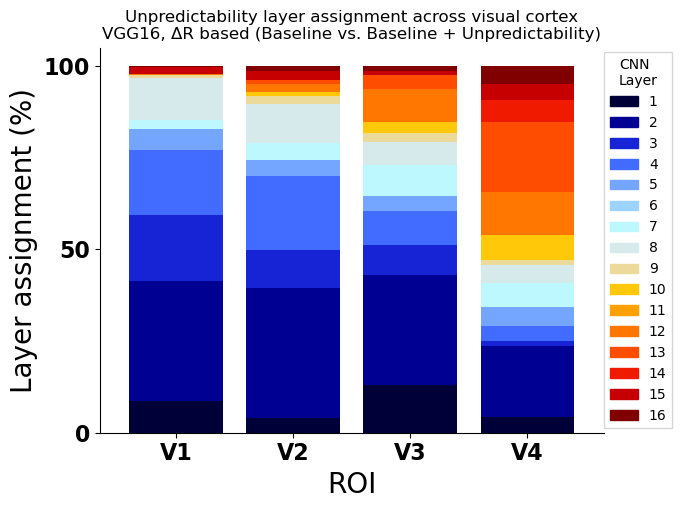

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


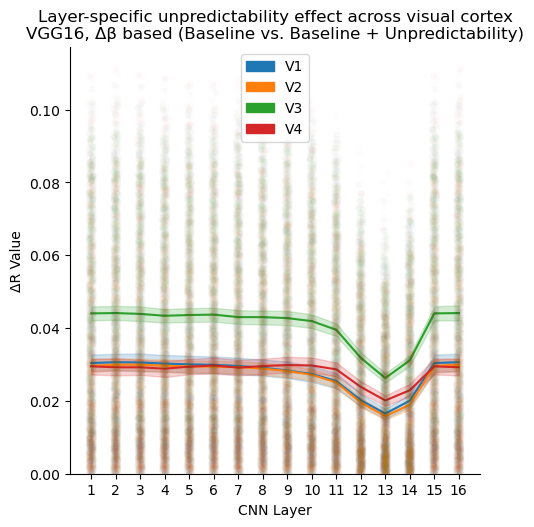

In [39]:
for subject in NSP.subjects[:1]:
    vgg18results = rd(subject=subject, folder="unpred/vggfull_GABORTEST_4sf_8dir", model="vggfull", statistic="delta_r", verbose=False, skip_norm_lay = True) # Norm layer is not in the encoding featmaps (i think)
    vgg18results.df
    vgg18results.assign_layers(max_or_weighted="max",
                            verbose=True,
                            title="Unpredictability layer assignment across visual cortex\nVGG16, ΔR based (Baseline vs. Baseline + Unpredictability)",
                            #   figsize = (6 , 5.5))
                            figsize = (6.5 , 5))



    vgg18results.mean_lines(fit_polynom = False,
                polynom_order = 4,
                verbose = True,
                plot_catplot = True,
                title = "Layer-specific unpredictability effect across visual cortex\nVGG16, Δβ based (Baseline vs. Baseline + Unpredictability)")

In [24]:
from classes.regdata import RegData
from funcs.reloads import Reloader
NSP = NatSpatPred()
NSP.initialise(verbose=True)
# importlib.reload(funcs.brain_mapping)
from funcs.brain_mapping import reg_to_nifti, vol_to_surf

rd = RegData
rl = Reloader

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [ ]:
angle = 330
stat = "delta_r"
for subject in NSP.subjects:

    results = rd(subject = subject, folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}", model="vggfull", statistic=stat, skip_norm_lay = True, verbose=True)
    # results = rd(subject = subject, folder=f"unpred/vggfull", model="vggfull", statistic="beta_unpred", skip_norm_lay = True)


    results.assign_layers(max_or_weighted = "weighted",
                        verbose = False,
                        title = f"Unpredictability layer assignment across visual cortex\nVGG16 ecc 2.0 angle {angle}°, ΔR based (Baseline vs. Baseline + Unpredictability)",
                        input_df = None,
                        figsize = (6.5 , 5))

    results.mean_lines(fit_polynom=False,
                    polynom_order=1,
                    plot_catplot=True,
                    title="PERIPHERAL",
                    verbose=True
                    )
        
        

    
    results = rd(subject = subject, folder=f"unpred/vggfull", model="vggfull", statistic=stat, skip_norm_lay = True)


    # results.assign_layers(max_or_weighted = "weighted",
    #                     verbose = True,
    #                     title = f"Unpredictability layer assignment across visual cortex\nVGG16 ecc 2.0 angle {angle}°, ΔR based (Baseline vs. Baseline + Unpredictability)",
    #                     input_df = None,
    #                     figsize = (6.5 , 5))

    results.mean_lines(fit_polynom=False,
                    polynom_order=1,
                    plot_catplot=True,
                    title="CENTRAL"
                    )
        
            
        # results = rd(subject = "subj01", folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}", model="vggfull", statistic="delta_r", skip_norm_lay = True)
        # results.assign_layers("max")
        
        
results.df


Using a copy of the DataFrame for layer assignment, the original DataFrame will not be changed.
DataFrame changed: Values normalised by dividing by the maximum value for each voxel (row), min values capped at 0.
DataFrame changed: Added weighted means of the relative CNN-layer delta-R ranking to the DataFrame.
Number of layers: 13


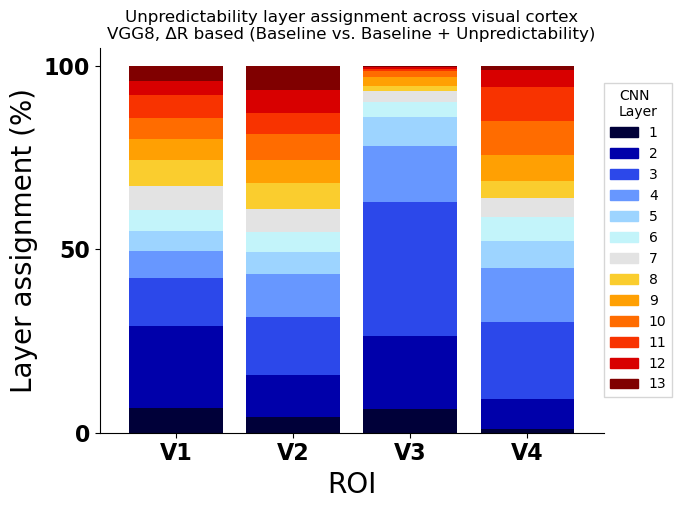

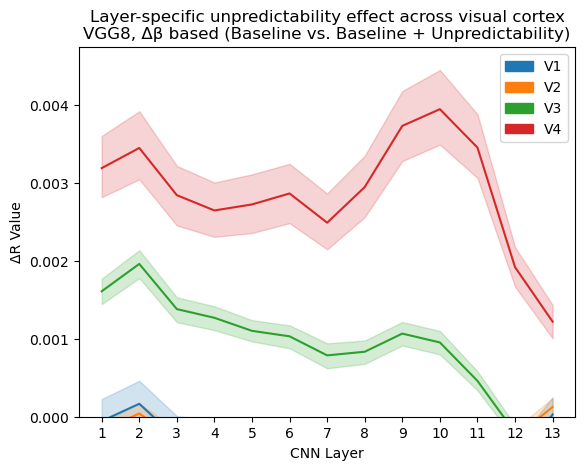

In [26]:
# for subject in NSP.subjects:
subject = "subj01"

# /home/rfpred/data/custom_files/subj01/results/unpred/vggfull_GABORTEST

vgg8results = rd(subject=subject, folder="unpred/vggfull_GABORTEST", model="vggfull", statistic="delta_r", verbose=False, skip_norm_lay = True)

vgg8results.assign_layers(max_or_weighted="weighted",
                        verbose=True,
                        title="Unpredictability layer assignment across visual cortex\nVGG8, ΔR based (Baseline vs. Baseline + Unpredictability)",
                        #   figsize = (6 , 5.5))
                        figsize = (6.5 , 5))



vgg8results.mean_lines(fit_polynom = False,
            polynom_order = 4,
            verbose = True,
            plot_catplot = False,
            title = "Layer-specific unpredictability effect across visual cortex\nVGG8, Δβ based (Baseline vs. Baseline + Unpredictability)")




